In [1]:
from dipy.data import get_sphere, default_sphere, get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, save_nifti
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import all_tensor_evecs
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model
from dipy.denoise.patch2self import patch2self
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, auto_response_ssst
from dipy.core.sphere import Sphere, HemiSphere, disperse_charges
from dipy.segment.tissue import TissueClassifierHMRF
from dipy.io.peaks import save_peaks
import dipy.reconst.dti as dti
from dipy.sims.voxel import add_noise
# Custom utilities
from faster_multitensor import multi_tensor
from utils.geometry import angle_between, is_angle_valid
from utils.distribution import bingham_dictionary
import numpy as np

sphere = get_sphere('repulsion724')

def get_dperp_extra(d_par, f_intra):
    return d_par * (1 - f_intra) / (1 + f_intra)
target_sphere = sphere.vertices
tortuisity = False

/tmp/ipykernel_1187427/1316683034.py:21: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  sphere = get_sphere('repulsion724')


In [2]:
def create_sphere(dirs):
    """Create a sphere with a specified number of directions."""
    rng = np.random.default_rng()
    theta = np.pi * rng.random(dirs)
    phi = 2 * np.pi * rng.random(dirs)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, _ = disperse_charges(hsph_initial, 5000)
    sph = Sphere(xyz=np.vstack((hsph_updated.vertices, -hsph_updated.vertices)))
    return sph


def create_gtab(dirs, b_val):
    """Create a gradient table for a given number of directions and b-value."""
    sph = create_sphere(dirs)
    # Add a b=0 image
    bvecs = np.zeros((len(sph.vertices) + 1, 3))
    bvecs[1:] = sph.vertices
    bvals = np.zeros((len(sph.vertices) + 1,))
    bvals[1:] = b_val
    gtab = gradient_table(bvals, bvecs)
    return gtab


def generate_pairs_in_bucket(sphere, lower_deg, upper_deg, num_samples):
    """
    Generate unique vertex pairs from the sphere with an angle between
    lower_deg and upper_deg. Angles are in degrees.

    Parameters:
        sphere : dipy.core.sphere.Sphere
            The sphere object whose vertices will be used.
        lower_deg : float
            Lower bound of the angular bucket (in degrees).
        upper_deg : float
            Upper bound of the angular bucket (in degrees).
        num_samples : int
            Number of unique vertex pairs to generate.

    Returns:
        pairs_list : list of tuples
            A list of unique vertex index pairs (i, j) such that the angle
            between the vectors corresponding to these vertices is between lower_rad and upper_rad.
    """
    lower_rad = np.deg2rad(lower_deg)
    upper_rad = np.deg2rad(upper_deg)
    pairs = set()
    attempts = 0
    max_attempts = num_samples * 1000 

    sphere_vertices = sphere.vertices

    while len(pairs) < num_samples and attempts < max_attempts:
        i = np.random.randint(0, len(sphere_vertices))
        j = np.random.randint(0, len(sphere_vertices))
        if i == j or np.array_equal(sphere_vertices[i], -sphere_vertices[j]):
             attempts += 1
             continue

        ang = angle_between(sphere_vertices[i], sphere_vertices[j])

        if lower_rad <= ang < upper_rad:
            pair = tuple(sorted((i, j)))
            pairs.add(pair)
        attempts += 1

    if len(pairs) < num_samples:
        print(f"Warning: Only generated {len(pairs)} pairs for bucket {lower_deg}-{upper_deg}° after {attempts} attempts.",flush=True)
    return list(pairs)

sphere = get_sphere('repulsion724')

buckets = [
    (10, 20),
    (20, 30),
    (30, 40),
    (40, 50),
    (50, 60),
    (60, 70),
    (70, 80),
    (80, 90)
]
num_samples = 1000
pairs = {}
for lower_deg, upper_deg in buckets:
    pairs[(lower_deg, upper_deg)] = generate_pairs_in_bucket(sphere, lower_deg, upper_deg, num_samples)
print("Pairs generated for all buckets.")
print("Number of pairs in each bucket:")
for bucket, pair_list in pairs.items():
    print(f"Bucket {bucket}: {len(pair_list)} pairs")



/tmp/ipykernel_1187427/3814295461.py:70: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  sphere = get_sphere('repulsion724')


Pairs generated for all buckets.
Number of pairs in each bucket:
Bucket (10, 20): 1000 pairs
Bucket (20, 30): 1000 pairs
Bucket (30, 40): 1000 pairs
Bucket (40, 50): 1000 pairs
Bucket (50, 60): 1000 pairs
Bucket (60, 70): 1000 pairs
Bucket (70, 80): 1000 pairs
Bucket (80, 90): 1000 pairs


In [3]:
gtab = create_gtab(75, 2000)

/tmp/ipykernel_1187427/3814295461.py:20: UserWarning: Pass ['bvecs'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  gtab = gradient_table(bvals, bvecs)


In [4]:
print(gtab.bvals)

[   0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [5]:
gtab.bvecs

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.9227275 , -0.0379742 ,  0.38357778],
       [ 0.03482225, -0.94302878,  0.33088387],
       [-0.37191143,  0.78784975,  0.49089169],
       [-0.80910752,  0.39167   ,  0.43810916],
       [ 0.15020721, -0.171154  ,  0.97372691],
       [ 0.99208328,  0.01930122,  0.1240896 ],
       [-0.8328952 , -0.54596781,  0.09058002],
       [ 0.95756367, -0.27384771,  0.08988467],
       [ 0.95063034,  0.31028556,  0.0049825 ],
       [ 0.53584184,  0.78970832,  0.29872111],
       [-0.3490825 , -0.12476643,  0.92874902],
       [-0.33561998, -0.42596771,  0.84018495],
       [ 0.39499264,  0.91854427,  0.01603896],
       [ 0.16648164, -0.98577251,  0.02316103],
       [ 0.58087694,  0.39361969,  0.71249247],
       [ 0.18765535, -0.80931272,  0.55659536],
       [ 0.91417745,  0.2811078 ,  0.29198973],
       [ 0.49035868, -0.76026156,  0.4260877 ],
       [-0.32364818,  0.18354428,  0.92820437],
       [-0.5798441 ,  0.53074329,  0.618

In [6]:
# create a signal with standard model with dispersion
odi_list = np.linspace(0.01, 0.3, 10)
evecs = np.array([all_tensor_evecs(tuple(point)) for point in sphere.vertices])
bingham_sf = bingham_dictionary(sphere.vertices, odi_list)

In [7]:
def generate_two_fibers(index, odi_list,bingham_sf):
    """Generate a two-fiber diffusion signal with random parameters."""
    f_in = np.random.uniform(0.6,0.9,2)
    fiber_frac1 = np.random.uniform(0.2,0.8)
    fiber_fractions = [fiber_frac1,1 - fiber_frac1]

    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3,1.5e-3)

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3
    

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    factor = np.random.choice(odi_list)
    
    S = np.zeros((len(bvals)))
    fodf = np.zeros((target_sphere.shape[0]))
    for i in range(2):
        fodf_gt = bingham_sf[index[i]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fractions[i] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

        # choose intra and extra axonal fractions with free water for compartments between 30 and 70%
        f_intra = f_in[i]
        f_extra = 1 - f_intra
        
        S += fiber_fractions[i]*(f_intra * S_in + f_extra * S_ex)

        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
        labels[index[0]] = 1
        labels[index[1]] = 1
    return S * S0, labels , 2, factor, 0, fiber_fractions[0] * f_in[0] + fiber_fractions[1] * f_in[1], fodf, d_par, fiber_fractions[0] * (1 - f_in[0])* d_perp_extra + fiber_fractions[1] * (1 - f_in[1]) * d_perp_extra, [fiber_frac1, 1 - fiber_frac1, 0], f_in

In [8]:
def create_gm_signal():
    """Generate a gray matter signal (isotropic)."""
    d = 1.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, d


def create_csf_signal():
    """Generate a CSF signal (isotropic)."""
    d = 3.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, d

In [9]:
def generate_two_fibers_with_tissue(index, odi_list, bingham_sf):
    """Generate a two-fiber diffusion signal with GM and CSF tissue contributions."""
    
    # Sample tissue fractions for WM, GM, and CSF using Dirichlet distribution
    # Higher weight for WM (white matter with fibers)
    fractions = [0,0,0]
    while fractions[0]<0.8:
        fractions = np.random.dirichlet([2, 0.01, 1])  # WM, GM, CSF
    wm_fraction = fractions[0]
    gm_fraction = fractions[1]
    csf_fraction = fractions[2]
    
    # Generate white matter signal (two fibers)
    wm_signal, labels, num_fibers, odi, fw, f_in_total, fodf, d_par, d_perp, fiber_fracs, f_in_vals = generate_two_fibers(index, odi_list, bingham_sf)
    
    # Generate GM and CSF signals
    gm_signal, gm_d = create_gm_signal()
    csf_signal, csf_d = create_csf_signal()
    
    # Combine signals weighted by tissue fractions
    combined_signal = wm_fraction * wm_signal + gm_fraction * gm_signal + csf_fraction * csf_signal
    
    # Return combined signal and metadata
    # Note: labels, fodf are only for WM component
    return (combined_signal, labels, num_fibers, odi, csf_fraction, 
            wm_fraction * f_in_total, fodf, d_par, d_perp, 
            [wm_fraction, gm_fraction, csf_fraction], fiber_fracs, f_in_vals, 
            gm_d, csf_d)

In [10]:
len(pairs[(10, 20)])

1000

In [11]:
repulsion724 = get_sphere('repulsion724')
xyz = repulsion724.vertices
np.savetxt("repulsion724_xyz.txt", xyz)

/tmp/ipykernel_1187427/3321190397.py:1: UserWarning: Pass ['name'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  repulsion724 = get_sphere('repulsion724')


In [12]:
# Generate signals for 2 pairs from each bucket with tissue fractions (WM, GM, CSF)
signals = []
metadata = []

# Extract bvals and bvecs from gtab
bvals = gtab.bvals
bvecs = gtab.bvecs

# Set target_sphere and tortuosity flag for generate_two_fibers function
target_sphere = sphere.vertices
tortuisity = False  # Set to False for random d_perp_extra

# Generate signals for 2 pairs from each bucket
for bucket, pair_list in pairs.items():
    print(f"Processing bucket {bucket}...")
    # Take first 2 pairs from each bucket
    for pair_idx in range(min(2000, len(pair_list))):
        pair = pair_list[pair_idx]
        
        # Generate signal for this pair with GM and CSF tissue fractions
        result = generate_two_fibers_with_tissue(pair, odi_list, bingham_sf)
        (signal, labels, num_fibers, odi, csf_fraction, f_in_total, fodf, d_par, d_perp, 
         tissue_fractions, fiber_fracs, f_in_vals, gm_d, csf_d) = result
        
        signals.append(signal)
        metadata.append({
            'bucket': bucket,
            'pair_indices': pair,
            'labels': labels,
            'num_fibers': num_fibers,
            'odi': odi,
            'csf_fraction': csf_fraction,
            'tissue_fractions': tissue_fractions,  # [WM, GM, CSF]
            'f_in_total': f_in_total,
            'fodf': fodf,
            'd_par': d_par,
            'd_perp': d_perp,
            'fiber_fractions': fiber_fracs,
            'f_in_values': f_in_vals,
            'gm_diffusivity': gm_d,
            'csf_diffusivity': csf_d
        })

print(f"\nGenerated {len(signals)} signals total ({len(pairs)} buckets × 2 pairs each)")
print(f"Signal shape: {signals[0].shape}")
print(f"\nExample tissue fractions (WM, GM, CSF): {metadata[0]['tissue_fractions']}")

Processing bucket (10, 20)...
Processing bucket (20, 30)...
Processing bucket (30, 40)...
Processing bucket (40, 50)...
Processing bucket (50, 60)...
Processing bucket (60, 70)...
Processing bucket (70, 80)...
Processing bucket (80, 90)...

Generated 8000 signals total (8 buckets × 2 pairs each)
Signal shape: (151,)

Example tissue fractions (WM, GM, CSF): [0.9653077659918149, 1.3519379863210168e-29, 0.03469223400818522]


In [13]:
print(len(signals))
print(len(signals[0]))

8000
151


In [14]:
# Import additional modules for large-scale simulation
import ray
from tqdm import tqdm
import psutil
import os
import gc

In [15]:
def generate_single_fiber():
    """Generate a single-fiber diffusion signal with random parameters."""
    # choose intra and extra axonal fractions with free water for compartments between 30 and 70%
    f_intra = np.random.uniform(0.6, 0.9)
    f_extra = 1 - f_intra

    fiber_fractions = 1

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_intra)
    else:
        d_perp_extra = np.random.uniform(0.3e-3,1.5e-3)

    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 1)[0]
    true_stick = target_sphere[index]
    factor = np.random.choice(odi_list)

    fodf_gt = bingham_sf[index][factor]
    fodf_gt = fodf_gt / np.sum(fodf_gt)

    S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
    S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

    # simulate the signal
    S = fiber_fractions*(f_intra * S_in + f_extra * S_ex)

    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick, axis=1))] = 1
    labels[index] = 1
    return S * S0, labels, 1, factor, 0, fiber_fractions * f_intra, fodf_gt, d_par, f_extra * d_perp_extra, [1,0,0], [f_intra]


def generate_two_fibers_sim():
    """Generate a two-fiber diffusion signal with random parameters (from simulation.py)."""
    f_in = np.random.uniform(0.6,0.9,2)
    fiber_frac1 = np.random.uniform(0.2,0.8)
    fiber_fractions = [fiber_frac1,1 - fiber_frac1]

    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3,1.5e-3)

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 2)
    while index[0] == index[1]:
        index = np.random.randint(0, target_sphere.shape[0], 2)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    factor = np.random.choice(odi_list)
    
    S = np.zeros((len(bvals)))
    fodf = np.zeros((target_sphere.shape[0]))
    for i in range(2):
        fodf_gt = bingham_sf[index[i]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fractions[i] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

        f_intra = f_in[i]
        f_extra = 1 - f_intra
        
        S += fiber_fractions[i]*(f_intra * S_in + f_extra * S_ex)

        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
        labels[index[0]] = 1
        labels[index[1]] = 1
    return S * S0, labels , 2, factor, 0, fiber_fractions[0] * f_in[0] + fiber_fractions[1] * f_in[1], fodf, d_par, fiber_fractions[0] * (1 - f_in[0])* d_perp_extra + fiber_fractions[1] * (1 - f_in[1]) * d_perp_extra, [fiber_frac1, 1 - fiber_frac1, 0], f_in


def generate_three_fibers():
    """Generate a three-fiber diffusion signal with random parameters."""
    f_in = np.random.uniform(0.6,0.9,3)
    fiber_fracs = np.random.dirichlet([1, 1, 1])
    while any(fiber_fracs < 0.2):
        fiber_fracs = np.random.dirichlet([1, 1, 1])
    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3,1.5e-3)

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = mevals_ex[:, 1]

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 3)

    # if indexes are closer than 70 degrees, choose another one
    while (not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[1]]),threshold=70) or 
    not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[2]]),threshold=70) or 
    not is_angle_valid(angle_between(target_sphere[index[1]], target_sphere[index[2]]),threshold=70)):
        index = np.random.randint(0, target_sphere.shape[0], 3)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    true_stick3 = target_sphere[index[2]]
    factor = np.random.choice(odi_list)
    
    fodf = np.zeros((target_sphere.shape[0]))
    S = np.zeros((len(bvals)))
    for k in range(3):
        fodf_gt = bingham_sf[index[k]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fracs[k] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

        S+= fiber_fracs[k]*(f_in[k] * S_in + (1 - f_in[k]) * S_ex)

    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick3, axis=1))] = 1
    labels[index[0]] = 1
    labels[index[1]] = 1
    labels[index[2]] = 1
    return S * S0, labels , 3, factor, 0, fiber_fracs[0] * f_in[0] + fiber_fracs[1] * f_in[1] + fiber_fracs[2] * f_in[2], fodf, d_par, fiber_fracs[0] * (1 - f_in[0]) * d_perp_extra + fiber_fracs[1] * (1 - f_in[1]) * d_perp_extra + fiber_fracs[2] * (1 - f_in[2]) * d_perp_extra, fiber_fracs, f_in


def get_dperp_extra(d_par, f_intra):
    """Calculate perpendicular diffusivity based on tortuosity model."""
    return d_par * (1 - f_intra) / (1 + f_intra)


def create_wm_signal(num_fib):
    """Generate a white matter signal with random fiber configuration."""
    if num_fib == 1:
        return generate_single_fiber()
    elif num_fib == 2:
        return generate_two_fibers_sim()
    elif num_fib == 3:
        return generate_three_fibers()

In [16]:
def create_gm_signal_sim():
    """Generate a gray matter signal (isotropic)."""
    d = 1.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, np.zeros(len(target_sphere)), 0, 1.0, 0.0, 0.0, np.ones(len(target_sphere))/len(target_sphere), d, d


def create_csf_signal_sim():
    """Generate a CSF signal (isotropic)."""
    d = 3.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, np.zeros(len(target_sphere)), 0, 1.0, 1.0, 0.0, np.zeros(len(target_sphere)), d , d


def create_mixed_signal():
    """Generate a mixed signal combining WM, GM, and CSF."""
    # Randomly sample fractions for WM, GM, and CSF
    fractions = np.random.dirichlet([2, 1, 1])  # WM, GM, CSF

    wm_fraction = fractions[0]
    gm_fraction = fractions[1]
    csf_fraction = fractions[2]

    # Choose a random number of fibers for WM
    num_fiber = np.random.choice([1,2,3], p=[0.1, 0.2, 0.7])

    # create signals for each tissue type
    wm_signal, wm_label, wm_num_fib, wm_disp, _, wm_nd, wm_odf, wm_d_par, wm_d_perp, fracs, f_ins = create_wm_signal(num_fib=num_fiber)
    gm_signal, _, _, gm_disp, _, gm_nd, gm_odf, gm_d_par, gm_d_perp = create_gm_signal_sim()
    csf_signal, _, _, _, csf_fw, _, csf_odf, csf_d_par, csf_d_perp = create_csf_signal_sim()
    
    # Combine signals weighted by tissue fractions
    combined_signal = fractions[0] * wm_signal + fractions[1] * gm_signal + fractions[2] * csf_signal
    
    # Get the combined ODI and ND
    odi = wm_fraction * wm_disp + gm_fraction * gm_disp + csf_fraction * 1.0
    nd = wm_fraction * wm_nd + gm_fraction * gm_nd

    combined_odf = np.zeros((724,))

    # Return all the metrics and signals
    return (
        combined_signal,
        wm_label,
        wm_num_fib,
        odi,
        wm_fraction,
        gm_fraction,
        csf_fraction,
        nd,
        combined_odf.astype(np.float16),
        fracs
    )

In [17]:
# Configuration for simulation
num_simulations = 1_000_000
num_cpus = psutil.cpu_count(logical=False)  # Use physical cores
dtype_config = np.float32
label_dtype = np.uint8
target_sphere = sphere.vertices
tortuisity = False  # Set to False for random d_perp_extra
bvals = gtab.bvals
bvecs = gtab.bvecs
output_dir = "simulation_output_1M"
os.makedirs(output_dir, exist_ok=True)

print(f"Configuration:")
print(f"  Number of simulations: {num_simulations:,}")
print(f"  Number of CPUs: {num_cpus}")
print(f"  Output directory: {output_dir}")
print(f"  Signal dtype: {dtype_config}")
print(f"  Label dtype: {label_dtype}")

Configuration:
  Number of simulations: 1,000,000
  Number of CPUs: 16
  Output directory: simulation_output_1M
  Signal dtype: <class 'numpy.float32'>
  Label dtype: <class 'numpy.uint8'>


In [ ]:
# Define Ray remote function
@ray.remote
def generate_mixed():
    return create_mixed_signal()

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
    
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
print(f"Ray initialized with {num_cpus} CPUs")

2025-11-22 20:42:07,170	INFO worker.py:1781 -- Started a local Ray instance.


Ray initialized with 16 CPUs


(raylet) Warning: The remote function __main__.generate_mixed is very large (40 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(generate_mixed pid=1187729) /home/athshah/miniconda3/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
(generate_mixed pid=1187729)   setattr(self, word, getattr(machar, word).flat[0])
(generate_mixed pid=1187729) /home/athshah/miniconda3/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
(generate_mixed pid=1187729)   return self._float_to_str(self.smallest_subnormal)


(generate_mixed pid=1187726) :ta
(generate_mixed pid=1187726) sk_name:generate_mixed


In [19]:
# Generate mixed signals in parallel
print(f"Starting simulation of {num_simulations:,} signals...")
print(f"This will generate 1, 2, and 3 fiber configurations with GM and CSF tissue fractions")

# Submit all tasks
futures = [generate_mixed.remote() for _ in range(num_simulations)]

# Collect results with progress bar
results = []
for future in tqdm(futures, desc="Generating mixed signals"):
    results.append(ray.get(future))

print(f"\nSimulation complete! Generated {len(results):,} signals")

Starting simulation of 1,000,000 signals...
This will generate 1, 2, and 3 fiber configurations with GM and CSF tissue fractions


Generating mixed signals: 100%|██████████| 1000000/1000000 [08:56<00:00, 1862.29it/s]


Simulation complete! Generated 1,000,000 signals


In [20]:
# Preallocate arrays
print("Preallocating arrays for data storage...")
signals_array = np.zeros((num_simulations, len(bvals)), dtype=dtype_config)
labels_array = np.zeros((num_simulations, len(target_sphere)), dtype=label_dtype)
num_fibers_array = np.zeros(num_simulations, dtype=dtype_config)
dispersion_array = np.zeros(num_simulations, dtype=dtype_config)
wm_fraction_array = np.zeros(num_simulations, dtype=dtype_config)
gm_fraction_array = np.zeros(num_simulations, dtype=dtype_config)
csf_fraction_array = np.zeros(num_simulations, dtype=dtype_config)
nd_array = np.zeros(num_simulations, dtype=dtype_config)
odfs_array = np.zeros((num_simulations, len(target_sphere)), dtype=np.float16)
fraction_array = np.zeros((num_simulations, 3), dtype=dtype_config)

print("Populating arrays from results...")
for i, res in enumerate(tqdm(results, desc="Processing results")):
    signals_array[i] = res[0]
    labels_array[i] = res[1]
    num_fibers_array[i] = res[2]
    dispersion_array[i] = res[3]
    wm_fraction_array[i] = res[4]
    gm_fraction_array[i] = res[5]
    csf_fraction_array[i] = res[6]
    nd_array[i] = res[7]
    odfs_array[i] = res[8]
    fraction_array[i] = res[9]

print("Arrays populated successfully!")

# Print statistics
print(f"\nSimulation Statistics:")
print(f"  1-fiber voxels: {np.sum(num_fibers_array == 1):,} ({100*np.mean(num_fibers_array == 1):.1f}%)")
print(f"  2-fiber voxels: {np.sum(num_fibers_array == 2):,} ({100*np.mean(num_fibers_array == 2):.1f}%)")
print(f"  3-fiber voxels: {np.sum(num_fibers_array == 3):,} ({100*np.mean(num_fibers_array == 3):.1f}%)")
print(f"  Mean WM fraction: {np.mean(wm_fraction_array):.3f}")
print(f"  Mean GM fraction: {np.mean(gm_fraction_array):.3f}")
print(f"  Mean CSF fraction: {np.mean(csf_fraction_array):.3f}")

# Clean up
del results
gc.collect()

Preallocating arrays for data storage...
Populating arrays from results...


Processing results: 100%|██████████| 1000000/1000000 [00:03<00:00, 322566.74it/s]


Arrays populated successfully!

Simulation Statistics:
  1-fiber voxels: 99,964 (10.0%)
  2-fiber voxels: 200,355 (20.0%)
  3-fiber voxels: 699,681 (70.0%)
  Mean WM fraction: 0.500
  Mean GM fraction: 0.250
  Mean CSF fraction: 0.250


0

In [21]:
# Save the results to disk
print(f"\nSaving results to {output_dir}...")

np.savez_compressed(
    os.path.join(output_dir, 'simulated_data.npz'),
    signals=signals_array,
    labels=labels_array,
    num_fibers=num_fibers_array,
    dispersion=dispersion_array,
    wm_fraction=wm_fraction_array,
    gm_fraction=gm_fraction_array,
    csf_fraction=csf_fraction_array,
    nd=nd_array,
    odfs=odfs_array,
    fraction_array=fraction_array,
    bvals=bvals,
    bvecs=bvecs
)

print(f"Results saved to {output_dir}/simulated_data.npz")
print(f"File size: {os.path.getsize(os.path.join(output_dir, 'simulated_data.npz')) / 1024**3:.2f} GB")


Saving results to simulation_output_1M...
Results saved to simulation_output_1M/simulated_data.npz
File size: 0.28 GB


In [22]:
# Shutdown Ray
ray.shutdown()
print("Ray shutdown complete.")

Ray shutdown complete.


## Add Noise to Simulated Signals

Now we'll add Gaussian noise at different SNR levels (10, 20, 50) to the simulated signals.

In [23]:
# Define SNR levels
snr_levels = [10, 20, 50, None]

print(f"Adding noise at SNR levels: {snr_levels}")
print(f"Signal array shape: {signals_array.shape}")
print(f"Number of signals to process: {len(signals_array):,}")

Adding noise at SNR levels: [10, 20, 50, None]
Signal array shape: (1000000, 151)
Number of signals to process: 1,000,000


In [24]:
# Create dictionary to store noisy signals for each SNR level for the simulated 2 fibers
snr_levels = [10, 20, 50, None]
dtype_config = np.float32

noisy_signals_dict = {}

for snr in snr_levels:
    print(f"\nAdding noise at SNR = {snr}...")
    
    # Preallocate array for this SNR level
    noisy_signals = np.zeros_like(signals, dtype=dtype_config)
    
    # Add noise to each signal
    for i in tqdm(range(len(signals)), desc=f"SNR {snr}"):
        # Use dipy's add_noise function
        # add_noise expects S0 and SNR, where SNR = S0 / sigma
        noisy_signals[i] = add_noise(signals[i], snr=snr, S0=100, noise_type='rician')
    
    # Store in dictionary
    noisy_signals_dict[snr] = noisy_signals
    
    print(f"Completed SNR {snr}: shape = {noisy_signals.shape}")

print(f"\nNoise addition complete for all SNR levels!")
print(f"Dictionary keys (SNR levels): {list(noisy_signals_dict.keys())}")

import pickle

# Save the noisy signals dictionary to a file
with open("noisy_signals_dict.pkl", "wb") as f:
    pickle.dump(noisy_signals_dict, f)

# save metadata as well
np.savez_compressed(
    "simulation_metadata.npz",
    metadata=metadata
)



Adding noise at SNR = 10...


SNR 10:   0%|          | 0/8000 [00:00<?, ?it/s]

SNR 10: 100%|██████████| 8000/8000 [00:00<00:00, 22216.03it/s]


Completed SNR 10: shape = (8000, 151)

Adding noise at SNR = 20...


SNR 20: 100%|██████████| 8000/8000 [00:00<00:00, 22243.10it/s]


Completed SNR 20: shape = (8000, 151)

Adding noise at SNR = 50...


SNR 50: 100%|██████████| 8000/8000 [00:00<00:00, 22172.65it/s]


Completed SNR 50: shape = (8000, 151)

Adding noise at SNR = None...


SNR None: 100%|██████████| 8000/8000 [00:00<00:00, 52456.34it/s]


Completed SNR None: shape = (8000, 151)

Noise addition complete for all SNR levels!
Dictionary keys (SNR levels): [10, 20, 50, None]


## Dictionary Matching with FAISS

Now we'll match the noisy signals to the clean dictionary using FAISS for fast cosine similarity search.

In [25]:
# Import FAISS
import faiss

print("FAISS version:", faiss.__version__)

FAISS version: 1.9.0


In [26]:
# Prepare dictionary (clean signals) for FAISS
print("Preparing dictionary for FAISS indexing...")

# Normalize dictionary signals for cosine similarity
dictionary_norm = signals_array / (np.linalg.norm(signals_array, axis=1, keepdims=True) + 1e-10)
dictionary_norm = dictionary_norm.astype(np.float32)

print(f"Dictionary shape: {dictionary_norm.shape}")
print(f"Dictionary dtype: {dictionary_norm.dtype}")
print(f"Dictionary normalized: min={dictionary_norm.min():.4f}, max={dictionary_norm.max():.4f}")

Preparing dictionary for FAISS indexing...
Dictionary shape: (1000000, 151)
Dictionary dtype: float32
Dictionary normalized: min=0.0006, max=0.9988


In [27]:
# Create FAISS index for cosine similarity (Inner Product on normalized vectors)
print("Creating FAISS index...")

dimension = dictionary_norm.shape[1]
index = faiss.IndexFlatIP(dimension)  # Inner Product index for cosine similarity
index.add(dictionary_norm)

print(f"FAISS index created!")
print(f"  Index type: IndexFlatIP (exact cosine similarity)")
print(f"  Dimension: {dimension}")
print(f"  Total vectors in index: {index.ntotal:,}")

Creating FAISS index...
FAISS index created!
  Index type: IndexFlatIP (exact cosine similarity)
  Dimension: 151
  Total vectors in index: 1,000,000


In [28]:
@ray.remote
def faiss_search(index, chunk_indices, maskdata_chunk_normalized, labels, penalized_array):
    """
    Perform FAISS search with penalty adjustment.
    
    Shapes:
    - D, I: (5000, 50)
    - labels: (N, 724)
    - penalized_array: matches I shape for broadcasting
    """
    # Get top-k nearest neighbors
    D, I = index.search(maskdata_chunk_normalized, k=50)
    
    # Apply penalties
    D = D - penalized_array[I]
    
    # Get indices of best matches after penalty
    best_indices = np.argmax(D, axis=1)  # Shape: (5000,)
    
    # Get the corresponding indices from I using advanced indexing
    final_indices = I[np.arange(len(best_indices)), best_indices]  # Shape: (5000,)
    
    # Map to labels
    closest_labels = labels[final_indices]  # Shape: (5000, 724)
    
    return closest_labels, chunk_indices, final_indices

## Dictionary Matching with Penalty Terms

Test different penalty values to penalize complex models (more fibers). The penalty is applied as: `penalty_weight * num_fibers`

In [29]:
# Define penalty values to test
penalty_values = [0.0, 0.00001, 0.0001, 0.001, 0.01]

print(f"Testing penalty values: {penalty_values}")
print(f"Penalty formula: adjusted_similarity = cosine_similarity - (penalty * num_fibers)")
print(f"\nThis penalizes models with more fibers, encouraging simpler explanations.")

Testing penalty values: [0.0, 1e-05, 0.0001, 0.001, 0.01]
Penalty formula: adjusted_similarity = cosine_similarity - (penalty * num_fibers)

This penalizes models with more fibers, encouraging simpler explanations.


In [30]:
# Function to match signals using FAISS with penalty
def match_signals_faiss_with_penalty(index, query_signals, penalized_array, k=50, batch_size=10000):
    """
    Match query signals to dictionary using FAISS index with penalty adjustment.
    
    Parameters:
    -----------
    index : faiss.Index
        FAISS index containing normalized dictionary signals
    query_signals : np.ndarray
        Query signals to match (will be normalized internally)
    penalized_array : np.ndarray
        Penalty values for each dictionary entry (penalty * num_fibers)
    k : int
        Number of nearest neighbors to retrieve
    batch_size : int
        Process queries in batches to manage memory
        
    Returns:
    --------
    distances : np.ndarray
        Adjusted similarities (after penalty) for best matches
    indices : np.ndarray
        Indices of matched dictionary entries (after penalty adjustment)
    """
    # Normalize query signals
    query_norm = query_signals / (np.linalg.norm(query_signals, axis=1, keepdims=True) + 1e-10)
    query_norm = query_norm.astype(np.float32)
    
    n_queries = len(query_norm)
    n_batches = int(np.ceil(n_queries / batch_size))
    
    all_distances = []
    all_indices = []
    
    for i in tqdm(range(n_batches), desc="Matching batches with penalty"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_queries)
        batch = query_norm[start_idx:end_idx]
        
        # Search FAISS index for top-k neighbors
        D, I = index.search(batch, k)
        
        # Apply penalties
        penalties_for_neighbors = penalized_array[I]
        D_penalized = D - penalties_for_neighbors
        
        # Get best match after penalty
        best_indices_in_k = np.argmax(D_penalized, axis=1)
        final_indices = I[np.arange(len(best_indices_in_k)), best_indices_in_k]
        final_distances = D_penalized[np.arange(len(best_indices_in_k)), best_indices_in_k]
        
        all_distances.append(final_distances)
        all_indices.append(final_indices)
    
    distances = np.concatenate(all_distances)
    indices = np.concatenate(all_indices)
    
    return distances, indices

print("Matching function with penalty defined successfully!")

Matching function with penalty defined successfully!


In [31]:
# Match noisy signals for all SNR levels and all penalty values
matching_results_with_penalty = {}

for penalty_weight in penalty_values:
    print(f"\n{'='*80}")
    print(f"Testing penalty weight: {penalty_weight}")
    print(f"{'='*80}")
    
    # Compute penalty array: penalty = penalty_weight * num_fibers
    penalized_array = penalty_weight * num_fibers_array
    
    # Store results for this penalty weight
    matching_results_with_penalty[penalty_weight] = {}
    
    for snr in snr_levels:
        print(f"\nMatching signals for SNR = {snr}, Penalty = {penalty_weight}")
        
        # Get noisy signals for this SNR
        noisy_sigs = noisy_signals_dict[snr]
        
        # Match to dictionary with penalty
        distances, faiss_indices = match_signals_faiss_with_penalty(
            index, noisy_sigs, penalized_array, k=50, batch_size=10000
        )
        
        # Extract matched parameters
        matched_labels = labels_array[faiss_indices]
        matched_num_fibers = num_fibers_array[faiss_indices]
        matched_dispersion = dispersion_array[faiss_indices]
        matched_wm_fraction = wm_fraction_array[faiss_indices]
        matched_gm_fraction = gm_fraction_array[faiss_indices]
        matched_csf_fraction = csf_fraction_array[faiss_indices]
        matched_odfs = odfs_array[faiss_indices]
        
        print("Matched labels shape:", matched_labels.shape)


        # Store results
        matching_results_with_penalty[penalty_weight][snr] = {
            'distances': distances,
            'indices': faiss_indices,
            'matched_labels': matched_labels,
            'matched_num_fibers': matched_num_fibers,
            'matched_dispersion': matched_dispersion,
            'matched_wm_fraction': matched_wm_fraction,
            'matched_gm_fraction': matched_gm_fraction,
            'matched_csf_fraction': matched_csf_fraction,
            'matched_odfs': matched_odfs
        }
        
        # Print statistics
        print(f"  Mean adjusted similarity: {distances.mean():.4f}")
        print(f"  Fiber count distribution: 1-fiber={np.sum(matched_num_fibers==1):,}, "
              f"2-fiber={np.sum(matched_num_fibers==2):,}, 3-fiber={np.sum(matched_num_fibers==3):,}")

print(f"\n{'='*80}")
print("Matching complete for all SNR levels and penalty values!")
print(f"{'='*80}")


Testing penalty weight: 0.0

Matching signals for SNR = 10, Penalty = 0.0


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.09s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9627
  Fiber count distribution: 1-fiber=1,467, 2-fiber=4,905, 3-fiber=1,628

Matching signals for SNR = 20, Penalty = 0.0


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  5.00s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9870
  Fiber count distribution: 1-fiber=1,809, 2-fiber=5,855, 3-fiber=336

Matching signals for SNR = 50, Penalty = 0.0


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9959
  Fiber count distribution: 1-fiber=1,875, 2-fiber=6,038, 3-fiber=87

Matching signals for SNR = None, Penalty = 0.0


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9977
  Fiber count distribution: 1-fiber=1,865, 2-fiber=6,064, 3-fiber=71

Testing penalty weight: 1e-05

Matching signals for SNR = 10, Penalty = 1e-05


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9627
  Fiber count distribution: 1-fiber=1,490, 2-fiber=4,893, 3-fiber=1,617

Matching signals for SNR = 20, Penalty = 1e-05


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9870
  Fiber count distribution: 1-fiber=1,838, 2-fiber=5,836, 3-fiber=326

Matching signals for SNR = 50, Penalty = 1e-05


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9959
  Fiber count distribution: 1-fiber=1,906, 2-fiber=6,009, 3-fiber=85

Matching signals for SNR = None, Penalty = 1e-05


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.89s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9977
  Fiber count distribution: 1-fiber=1,905, 2-fiber=6,028, 3-fiber=67

Testing penalty weight: 0.0001

Matching signals for SNR = 10, Penalty = 0.0001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9625
  Fiber count distribution: 1-fiber=1,688, 2-fiber=4,827, 3-fiber=1,485

Matching signals for SNR = 20, Penalty = 0.0001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.87s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9868
  Fiber count distribution: 1-fiber=2,162, 2-fiber=5,579, 3-fiber=259

Matching signals for SNR = 50, Penalty = 0.0001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9957
  Fiber count distribution: 1-fiber=2,199, 2-fiber=5,743, 3-fiber=58

Matching signals for SNR = None, Penalty = 0.0001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9975
  Fiber count distribution: 1-fiber=2,207, 2-fiber=5,757, 3-fiber=36

Testing penalty weight: 0.001

Matching signals for SNR = 10, Penalty = 0.001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9609
  Fiber count distribution: 1-fiber=3,560, 2-fiber=3,992, 3-fiber=448

Matching signals for SNR = 20, Penalty = 0.001


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9854
  Fiber count distribution: 1-fiber=3,941, 2-fiber=4,046, 3-fiber=13

Matching signals for SNR = 50, Penalty = 0.001


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.00s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9943
  Fiber count distribution: 1-fiber=4,010, 2-fiber=3,988, 3-fiber=2

Matching signals for SNR = None, Penalty = 0.001


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9961
  Fiber count distribution: 1-fiber=4,037, 2-fiber=3,962, 3-fiber=1

Testing penalty weight: 0.01

Matching signals for SNR = 10, Penalty = 0.01


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9484
  Fiber count distribution: 1-fiber=5,421, 2-fiber=2,460, 3-fiber=119

Matching signals for SNR = 20, Penalty = 0.01


Matching batches with penalty: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9735
  Fiber count distribution: 1-fiber=5,843, 2-fiber=2,152, 3-fiber=5

Matching signals for SNR = 50, Penalty = 0.01


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9825
  Fiber count distribution: 1-fiber=5,974, 2-fiber=2,026, 3-fiber=0

Matching signals for SNR = None, Penalty = 0.01


Matching batches with penalty: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

Matched labels shape: (8000, 724)
  Mean adjusted similarity: 0.9843
  Fiber count distribution: 1-fiber=5,970, 2-fiber=2,030, 3-fiber=0

Matching complete for all SNR levels and penalty values!


In [32]:
# Compute matching accuracy by angular bucket
print("Computing matching accuracy by angular bucket...\n")

# Group signals by their original bucket
bucket_indices = {}
current_idx = 0

for bucket in buckets:
    bucket_key = bucket
    num_pairs_in_bucket = len(pairs[bucket])
    # Each bucket contributed min(2000, num_pairs_in_bucket) signals
    num_signals = min(2000, num_pairs_in_bucket)
    bucket_indices[bucket_key] = list(range(current_idx, current_idx + num_signals))
    current_idx += num_signals

print(f"Total signals from buckets: {current_idx}")
print(f"Bucket ranges:")
for bucket, indices in bucket_indices.items():
    print(f"  {bucket}: {len(indices)} signals (indices {indices[0]} to {indices[-1]})")


Computing matching accuracy by angular bucket...

Total signals from buckets: 8000
Bucket ranges:
  (10, 20): 1000 signals (indices 0 to 999)
  (20, 30): 1000 signals (indices 1000 to 1999)
  (30, 40): 1000 signals (indices 2000 to 2999)
  (40, 50): 1000 signals (indices 3000 to 3999)
  (50, 60): 1000 signals (indices 4000 to 4999)
  (60, 70): 1000 signals (indices 5000 to 5999)
  (70, 80): 1000 signals (indices 6000 to 6999)
  (80, 90): 1000 signals (indices 7000 to 7999)


In [33]:
# Compute accuracy for each bucket, penalty, and SNR
bucket_accuracy_results = {}

# Angular threshold for peak matching (in degrees)
angular_threshold = 20.0

def angle_between_with_antipodal(v1, v2):
    """
    Compute the angle between two vectors considering antipodal symmetry.
    Returns the smaller of the two angles (0-90 degrees).
    """
    cos_theta = np.clip(np.dot(v1, v2), -1.0, 1.0)
    angle = np.arccos(np.abs(cos_theta))  # abs() to get acute angle (antipodal symmetry)
    return angle

signals_q = np.asarray(signals, dtype=np.float32)                             # (Q, N_grad)
labels_q  = np.stack([m['labels'] for m in metadata]).astype(np.uint8)        # (Q, 724)
nfib_q    = np.array([m['num_fibers'] for m in metadata], dtype=np.int8)

for penalty_weight in penalty_values:
    bucket_accuracy_results[penalty_weight] = {}
    
    for snr in snr_levels:
        bucket_accuracy_results[penalty_weight][snr] = {}
        
        # Get predictions for this penalty/SNR combination
        pred_num_fibers_full = matching_results_with_penalty[penalty_weight][snr]['matched_num_fibers']
        pred_labels_full = matching_results_with_penalty[penalty_weight][snr]['matched_labels']
        print(pred_labels_full.shape)
        for bucket, indices in bucket_indices.items():
            # Extract ground truth and predictions for this bucket
            true_num_fibers = nfib_q[indices]
            true_labels_bucket = labels_q[indices]
            pred_num_fibers = pred_num_fibers_full[indices]
            pred_labels_bucket = pred_labels_full[indices]
            
            # Fiber count accuracy
            fiber_accuracy = np.mean(true_num_fibers == pred_num_fibers)
            
            # Angular-based peak detection with antipodal symmetry
            angular_errors = []
            peak_detection_success = 0
            
            for i in range(len(indices)):
                true_peak_indices = np.where(true_labels_bucket[i] == 1)[0]
                pred_peak_indices = np.where(pred_labels_bucket[i] == 1)[0]
                
                if len(true_peak_indices) == 0:
                    continue
                
                true_peak_dirs = target_sphere[true_peak_indices]
                
                
                
                pred_peak_dirs = target_sphere[pred_peak_indices]
                
                for true_dir in true_peak_dirs:
                    # Calculate angles with antipodal symmetry
                    angles = np.array([np.rad2deg(angle_between_with_antipodal(true_dir, pred_dir)) 
                                       for pred_dir in pred_peak_dirs])
                    min_angle = np.min(angles)
                    angular_errors.append(min_angle)
                    
                    if min_angle <= angular_threshold:
                        peak_detection_success += 1
        

            # Store results for this bucket
            peak_detection_rate = peak_detection_success / (2 * len(indices))
            mean_angular_error = np.mean(angular_errors) if len(angular_errors) > 0 else 0
            
            bucket_accuracy_results[penalty_weight][snr][bucket] = {
                'fiber_count_accuracy': fiber_accuracy,
                'peak_detection_rate': peak_detection_rate,
                'mean_angular_error': mean_angular_error,
                'num_signals': len(indices)
            }

print("Bucket accuracy computation complete!")
print(f"Note: Using antipodal symmetry - angles constrained to 0-90°")


(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
Bucket accuracy computation complete!
Note: Using antipodal symmetry - angles constrained to 0-90°


In [34]:
import numpy as np

# Try to use Hungarian algorithm; fall back to a greedy 1↔1 matcher if SciPy is not available.
try:
    from scipy.optimize import linear_sum_assignment
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def pairwise_angles_antipodal(A, B):
    """
    A: (m,3), B: (n,3) unit vectors.
    Returns the m×n matrix of antipodal-symmetric angles in degrees (0..90).
    """
    # dot(A, B) for all pairs
    cos = np.clip(A @ B.T, -1.0, 1.0)
    ang = np.rad2deg(np.arccos(np.abs(cos)))  # antipodal symmetry via abs
    return ang

def optimal_peak_matching(true_dirs, pred_dirs, threshold_deg, unmatched_cost=None):
    """
    One-to-one matching between true and predicted peak directions that:
      - maximizes number of pairs under threshold
      - minimizes total angle among feasible pairs
    Returns:
      pairs: list of (i_true, j_pred) indices into true_dirs/pred_dirs
      angles: np.array of per-pair angles in degrees (only matched pairs)
    """
    m = true_dirs.shape[0]
    n = pred_dirs.shape[0]

    if m == 0 or n == 0:
        return [], np.array([], dtype=np.float32)

    if unmatched_cost is None:
        # Make unmatched slightly more expensive than any valid match
        unmatched_cost = float(threshold_deg) + 1e-3

    # Pairwise antipodal angles
    D = pairwise_angles_antipodal(true_dirs, pred_dirs)  # shape (m, n)

    if _HAS_SCIPY:
        big = 1e6  # disallow over-threshold matches
        k = max(m, n)
        # Square cost matrix padded with "unmatched" cost so solver can leave items unmatched.
        C = np.full((k, k), unmatched_cost, dtype=np.float32)
        C[:m, :n] = D
        # Gate out over-threshold matches
        C[:m, :n][C[:m, :n] > threshold_deg] = big

        r, c = linear_sum_assignment(C)

        pairs, angles = [], []
        for i, j in zip(r, c):
            # Keep only real-real matches that beat the unmatched cost
            if i < m and j < n and C[i, j] < unmatched_cost:
                pairs.append((i, j))
                angles.append(D[i, j])
        return pairs, np.array(angles, dtype=np.float32)

    # ---- Greedy fallback (still 1↔1; may be suboptimal but fine for small m,n) ----
    edges = [(i, j, D[i, j]) for i in range(m) for j in range(n) if D[i, j] <= threshold_deg]
    edges.sort(key=lambda x: x[2])  # lowest angle first
    used_i, used_j = set(), set()
    pairs, angles = [], []
    for i, j, a in edges:
        if i not in used_i and j not in used_j:
            used_i.add(i); used_j.add(j)
            pairs.append((i, j))
            angles.append(a)
    return pairs, np.array(angles, dtype=np.float32)


In [35]:
# Compute accuracy for each bucket, penalty, and SNR
bucket_accuracy_results = {}

# Angular threshold for peak matching (in degrees)
angular_threshold = 20.0

def angle_between_with_antipodal(v1, v2):
    """
    Compute the angle between two vectors considering antipodal symmetry.
    Returns the smaller of the two angles (0-90 degrees).
    """
    cos_theta = np.clip(np.dot(v1, v2), -1.0, 1.0)
    angle = np.arccos(np.abs(cos_theta))  # abs() to get acute angle (antipodal symmetry)
    return angle

signals_q = np.asarray(signals, dtype=np.float32)                             # (Q, N_grad)
labels_q  = np.stack([m['labels'] for m in metadata]).astype(np.uint8)        # (Q, 724)
nfib_q    = np.array([m['num_fibers'] for m in metadata], dtype=np.int8)

for penalty_weight in penalty_values:
    bucket_accuracy_results[penalty_weight] = {}
    
    for snr in snr_levels:
        bucket_accuracy_results[penalty_weight][snr] = {}
        
        # Get predictions for this penalty/SNR combination
        pred_num_fibers_full = matching_results_with_penalty[penalty_weight][snr]['matched_num_fibers']
        pred_labels_full = matching_results_with_penalty[penalty_weight][snr]['matched_labels']
        print(pred_labels_full.shape)
        for bucket, indices in bucket_indices.items():
            # Extract ground truth and predictions for this bucket
            true_num_fibers = nfib_q[indices]
            true_labels_bucket = labels_q[indices]
            pred_num_fibers = pred_num_fibers_full[indices]
            pred_labels_bucket = pred_labels_full[indices]
            
            # Fiber count accuracy
            fiber_accuracy = np.mean(true_num_fibers == pred_num_fibers)
            
            # Angular-based peak detection with antipodal symmetry
            # --- Optimal 1↔1 matching across peaks per signal ---
            total_true_peaks = 0
            total_pred_peaks = 0
            total_matched_peaks = 0
            angular_errors = []  # matched-pair angles only

            for i in range(len(indices)):
                true_peak_indices = np.flatnonzero(true_labels_bucket[i] == 1)
                pred_peak_indices = np.flatnonzero(pred_labels_bucket[i] == 1)

                m = len(true_peak_indices)
                n = len(pred_peak_indices)

                total_true_peaks += m
                total_pred_peaks += n

                if m == 0:
                    # nothing to match for this sample; any predictions here are false positives
                    continue

                true_peak_dirs = target_sphere[true_peak_indices]  # (m, 3)
                pred_peak_dirs = target_sphere[pred_peak_indices]  # (n, 3)

                pairs, angles = optimal_peak_matching(true_peak_dirs, pred_peak_dirs, angular_threshold)

                total_matched_peaks += len(pairs)
                if angles.size > 0:
                    angular_errors.extend(angles.tolist())

            # Metrics for this bucket
            peak_recall = (total_matched_peaks / total_true_peaks) if total_true_peaks > 0 else 0.0          # matched / true
            peak_precision = (total_matched_peaks / total_pred_peaks) if total_pred_peaks > 0 else 0.0      # matched / predicted
            peak_f1 = (2 * peak_precision * peak_recall / (peak_precision + peak_recall)
                    if (peak_precision + peak_recall) > 0 else 0.0)
            mean_angular_error = float(np.mean(angular_errors)) if len(angular_errors) > 0 else 0.0
            
            bucket_accuracy_results[penalty_weight][snr][bucket] = {
        'fiber_count_accuracy': float(fiber_accuracy),
        'peak_detection_rate': float(peak_recall),  # recall (matched / true) instead of dividing by 2*len(indices)
        'peak_precision': float(peak_precision),
        'peak_f1': float(peak_f1),
        'mean_angular_error': mean_angular_error,   # over matched pairs only
        'num_signals': int(len(indices)),
        'num_true_peaks': int(total_true_peaks),
        'num_pred_peaks': int(total_pred_peaks),
        'num_matched_pairs': int(total_matched_peaks),
    }




(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)
(8000, 724)


In [36]:
buckets

[(10, 20),
 (20, 30),
 (30, 40),
 (40, 50),
 (50, 60),
 (60, 70),
 (70, 80),
 (80, 90)]

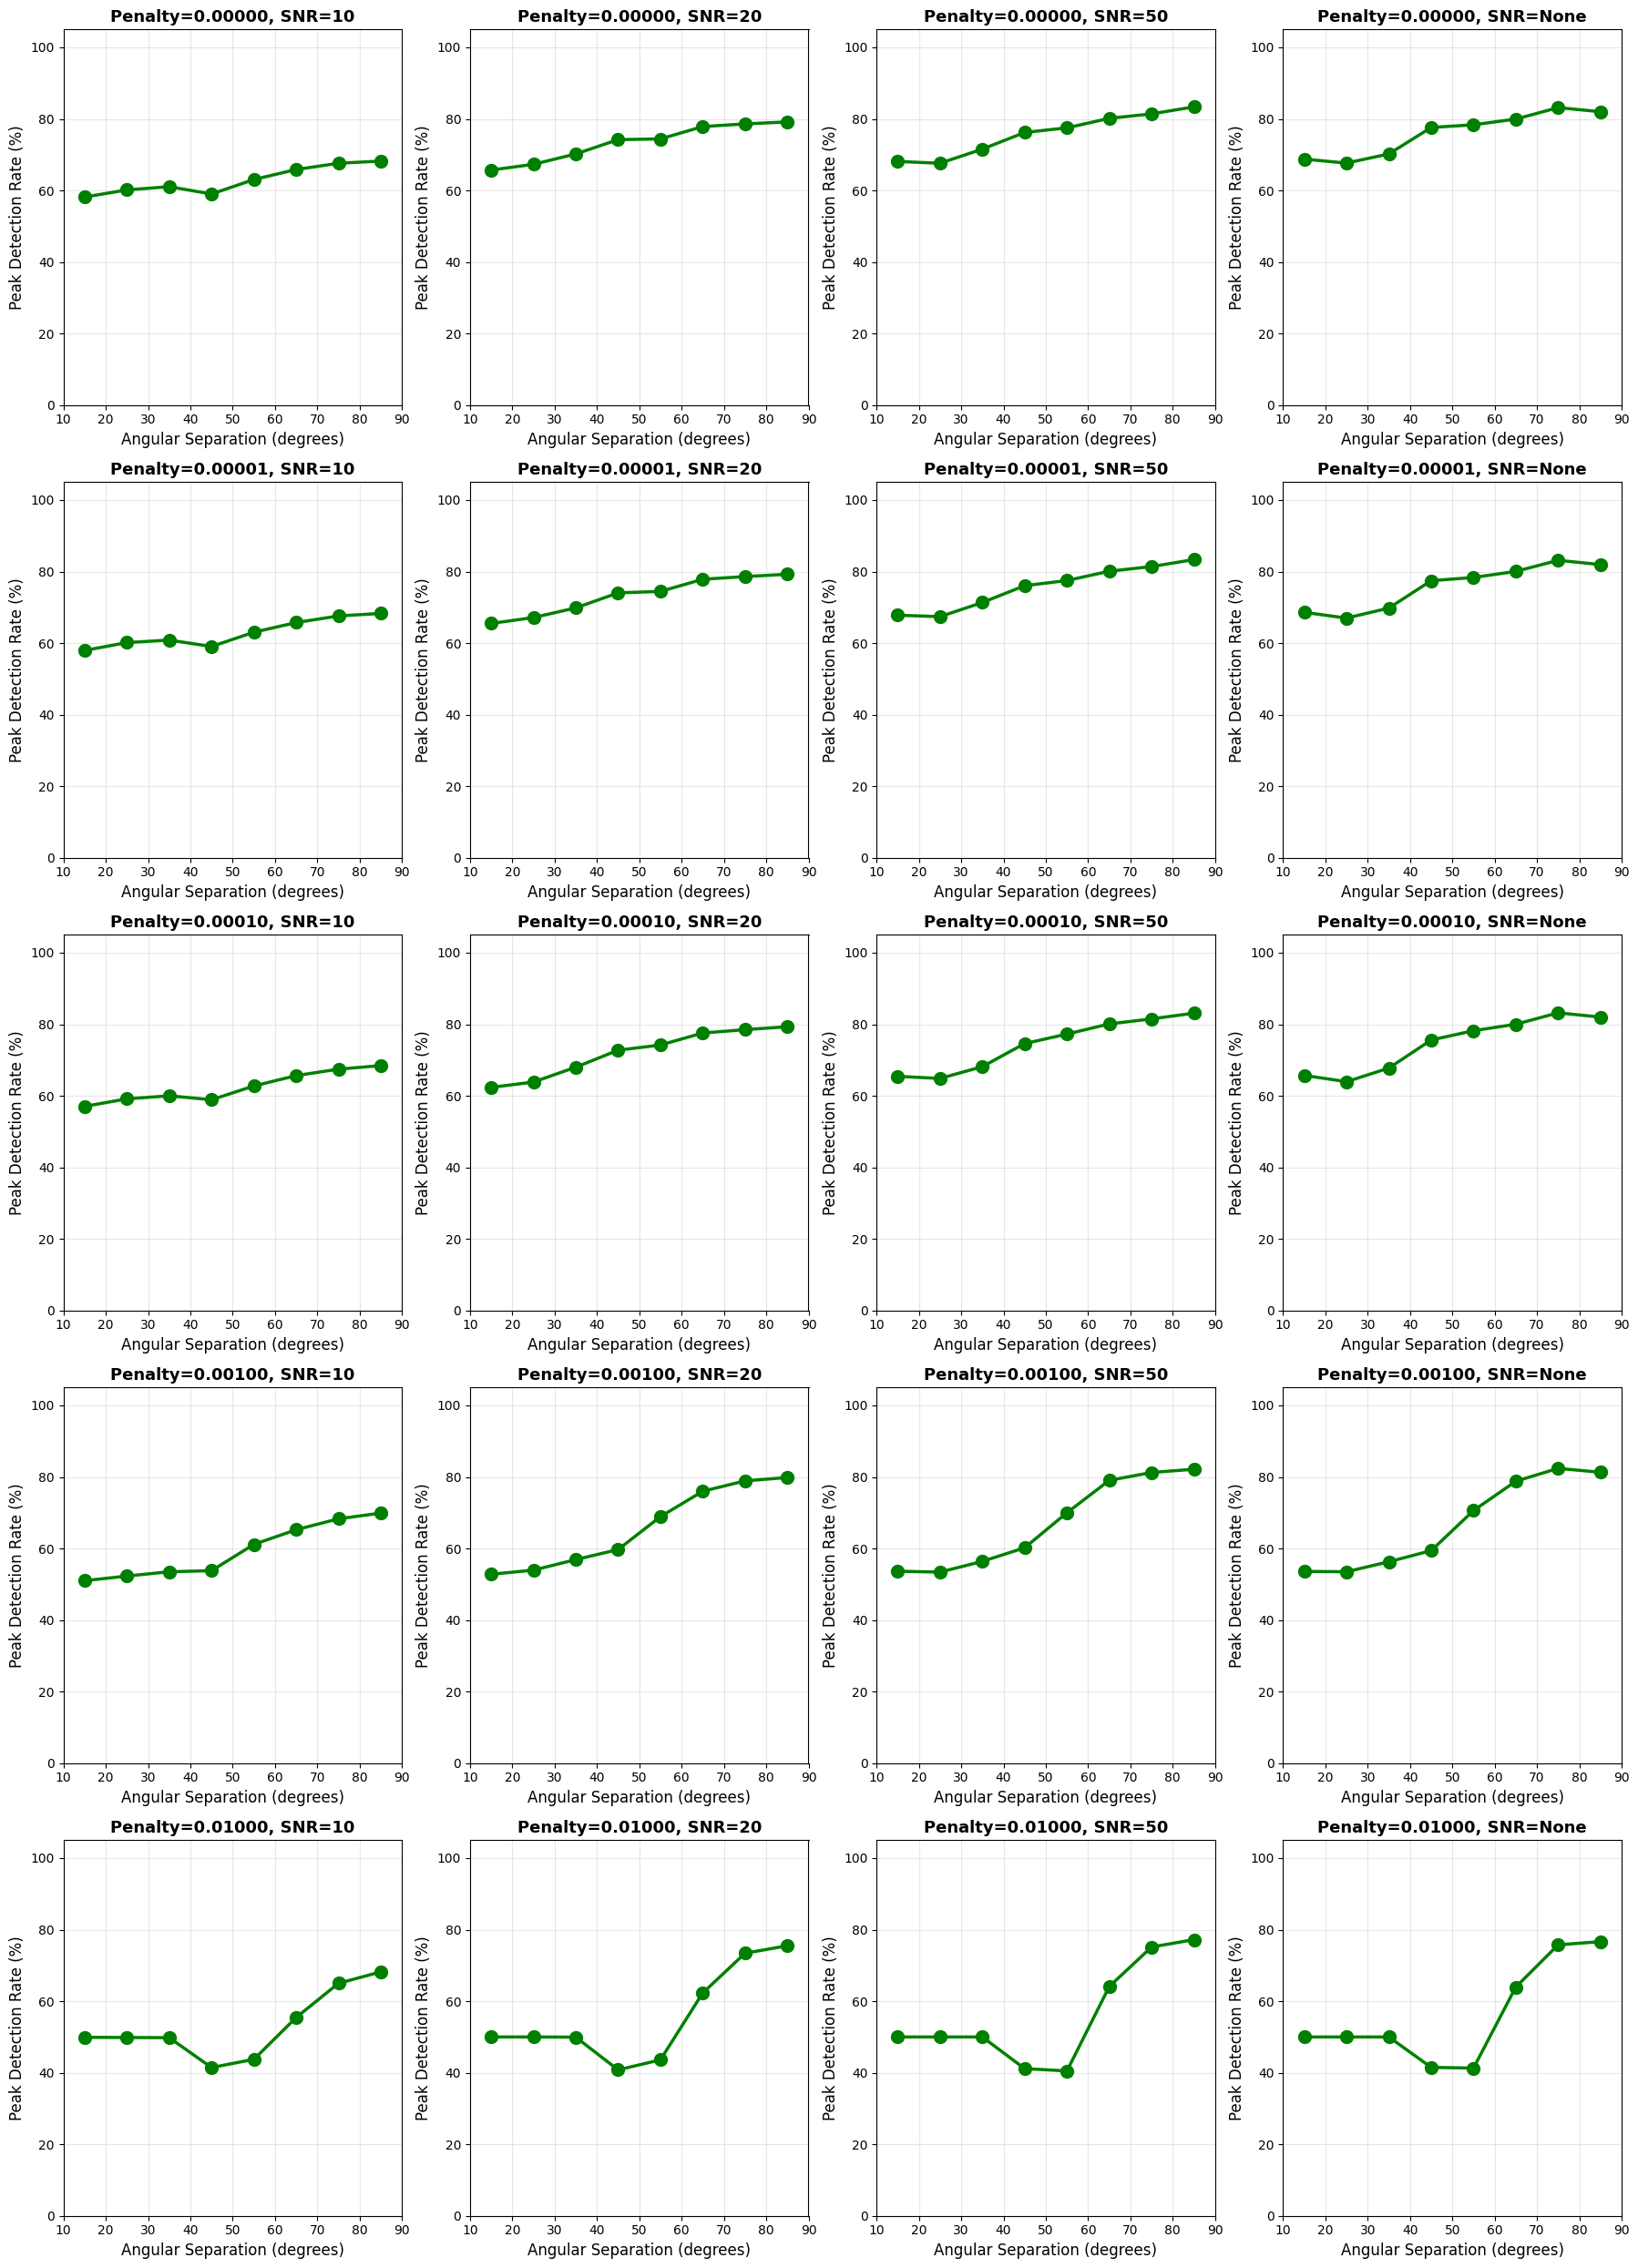


Visualization saved to simulation_output_1M/accuracy_by_bucket.png


In [37]:
# Visualize peak detection accuracy by angular bucket
import matplotlib.pyplot as plt

# Extract bucket centers for plotting
bucket_centers = [(lower + upper) / 2 for (lower, upper) in buckets]

# Create subplots for each penalty value
n_penalties = len(penalty_values)
fig, axes = plt.subplots(n_penalties, 4, figsize=(18, 5 * n_penalties))

if n_penalties == 1:
    axes = axes.reshape(1, -1)

for p_idx, penalty_weight in enumerate(penalty_values):
    for s_idx, snr in enumerate(snr_levels):
        ax = axes[p_idx, s_idx]
        
        # Extract peak detection rates for each bucket
        peak_det_rates = []
        
        for bucket in buckets:
            results = bucket_accuracy_results[penalty_weight][snr][bucket]
            peak_det_rates.append(results['peak_detection_rate'] * 100)
        
        # Plot
        ax.plot(bucket_centers, peak_det_rates, 'o-', linewidth=2.5, markersize=10, 
                color='green')
        
        ax.set_xlabel('Angular Separation (degrees)', fontsize=12)
        ax.set_ylabel('Peak Detection Rate (%)', fontsize=12)
        ax.set_title(f'Penalty={penalty_weight:.5f}, SNR={snr}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim([10, 90])
        ax.set_ylim([0, 105])

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'accuracy_by_bucket.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {output_dir}/accuracy_by_bucket.png")


In [38]:
# get a response function from the signals by getting signal with FA > 0.8
import dipy.reconst.dti as dti
dti_model  = dti.TensorModel(gtab)
dti_fit    = dti_model.fit(np.array(signals))
fa_values  = dti_fit.fa
high_fa_indices = np.where(fa_values > 0.8)[0]

evals = dti_fit.evals[high_fa_indices]
mean_evals = np.mean(evals, axis=0)

print("Estimated response function eigenvalues (from FA > 0.8):", mean_evals)
estimate = np.array(mean_evals, dtype=float)
ratio = 1/mean_evals.sum()
response = (estimate, ratio)
print("Response function", response)

Estimated response function eigenvalues (from FA > 0.8): [0.00187046 0.00027188 0.0002075 ]
Response function (array([0.00187046, 0.00027188, 0.0002075 ]), 425.5609645592445)


In [39]:
import numpy as np

# Try SciPy Hungarian; fall back to greedy if SciPy is unavailable.
try:
    from scipy.optimize import linear_sum_assignment
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def pairwise_angles_antipodal(A, B):
    """
    A: (m,3), B: (n,3) unit vectors.
    Returns m×n antipodal-symmetric angles in degrees in [0, 90].
    """
    cos = np.clip(A @ B.T, -1.0, 1.0)
    ang = np.rad2deg(np.arccos(np.abs(cos)))
    return ang

def optimal_peak_matching(true_dirs, pred_dirs, threshold_deg, unmatched_cost=None):
    """
    One-to-one matching maximizing matches <= threshold, then minimizing total angle.
    Returns:
      pairs: list[(i_true, j_pred)], angles: np.ndarray[deg] for matched pairs only.
    """
    m = true_dirs.shape[0]
    n = pred_dirs.shape[0]
    if m == 0 or n == 0:
        return [], np.array([], dtype=np.float32)

    if unmatched_cost is None:
        unmatched_cost = float(threshold_deg) + 1e-3

    D = pairwise_angles_antipodal(true_dirs, pred_dirs)

    if _HAS_SCIPY:
        big = 1e6
        k = max(m, n)
        C = np.full((k, k), unmatched_cost, dtype=np.float32)
        C[:m, :n] = D
        C[:m, :n][C[:m, :n] > threshold_deg] = big

        r, c = linear_sum_assignment(C)
        pairs, angles = [], []
        for i, j in zip(r, c):
            if i < m and j < n and C[i, j] < unmatched_cost:
                pairs.append((i, j))
                angles.append(D[i, j])
        return pairs, np.array(angles, dtype=np.float32)

    # Greedy fallback (still 1↔1)
    edges = [(i, j, D[i, j]) for i in range(m) for j in range(n) if D[i, j] <= threshold_deg]
    edges.sort(key=lambda x: x[2])
    used_i, used_j = set(), set()
    pairs, angles = [], []
    for i, j, a in edges:
        if i not in used_i and j not in used_j:
            used_i.add(i); used_j.add(j)
            pairs.append((i, j))
            angles.append(a)
    return pairs, np.array(angles, dtype=np.float32)

def get_valid_peak_dirs(peak_dirs_all):
    """
    peak_dirs_all: array-like of shape (Q, K, 3) (padded with zeros for missing peaks) 
                   or list/array where each item is (K,3).
    Returns:
      dirs_list: list of length Q; each item is (n_i, 3) unit vectors
      counts   : np.array shape (Q,) number of valid peaks per sample
    """
    peak_dirs_all = np.asarray(peak_dirs_all, dtype=np.float32)
    if peak_dirs_all.ndim == 2 and peak_dirs_all.shape[-1] == 3:
        peak_dirs_all = peak_dirs_all[np.newaxis, ...]  # single-sample case

    Q = peak_dirs_all.shape[0]
    dirs_list, counts = [], np.zeros(Q, dtype=np.int32)

    for i in range(Q):
        dirs_i = np.atleast_2d(peak_dirs_all[i])  # (K,3)
        valid = np.linalg.norm(dirs_i, axis=-1) > 1e-6
        V = dirs_i[valid]
        if V.size:
            V = V / np.linalg.norm(V, axis=-1, keepdims=True)
        dirs_list.append(V)
        counts[i] = V.shape[0]
    return dirs_list, counts

def evaluate_bucket(indices, pred_dirs_list, pred_counts, labels_q, nfib_q, target_dirs, angular_threshold):
    """
    Compute metrics for a set of signal indices given predicted peak dirs per sample.
    """
    total_true = 0
    total_pred = 0
    total_matched = 0
    ang_errors = []

    # Fiber count accuracy (per-sample equality)
    fiber_accuracy = float(np.mean(nfib_q[indices] == pred_counts[indices])) if len(indices) > 0 else 0.0

    for idx in indices:
        true_peak_indices = np.flatnonzero(labels_q[idx] == 1)
        m = len(true_peak_indices)
        pred_dirs = pred_dirs_list[idx]
        n = pred_dirs.shape[0]

        total_true += m
        total_pred += n

        if m == 0:
            continue

        true_dirs = target_dirs[true_peak_indices]  # (m,3)
        pairs, angles = optimal_peak_matching(true_dirs, pred_dirs, angular_threshold)
        total_matched += len(pairs)
        if angles.size:
            ang_errors.extend(angles.tolist())

    recall = (total_matched / total_true) if total_true > 0 else 0.0
    precision = (total_matched / total_pred) if total_pred > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    mean_ang = float(np.mean(ang_errors)) if ang_errors else 0.0

    return {
        'fiber_count_accuracy': fiber_accuracy,
        'peak_detection_rate': recall,      # recall (matched / true)
        'peak_precision': precision,
        'peak_f1': f1,
        'mean_angular_error': mean_ang,     # matched pairs only
        'num_signals': int(len(indices)),
        'num_true_peaks': int(total_true),
        'num_pred_peaks': int(total_pred),
        'num_matched_pairs': int(total_matched),
    }


In [40]:
from dipy.direction import peaks_from_model
from dipy.reconst.shm import CsaOdfModel
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, auto_response_ssst
from dipy.reconst.gqi import GeneralizedQSamplingModel

# Make sure target_sphere is an (N,3) ndarray of unit vectors
_target_dirs = target_sphere.vertices if hasattr(target_sphere, "vertices") else np.asarray(target_sphere, dtype=np.float32)

angular_threshold = 20.0  # degrees

# Build models once
csa = CsaOdfModel(gtab, sh_order=8)
csd = ConstrainedSphericalDeconvModel(gtab, response=response, sh_order=8)

gqi = GeneralizedQSamplingModel(gtab, sampling_length=1.25)

# Results: model → SNR → bucket → metrics
advanced_model_results = {'CSA': {}, 'CSD': {}, 'GQI': {}}

for snr in snr_levels:
    print(f"\nProcessing SNR = {snr} for advanced models...")
    noisy_sigs = noisy_signals_dict[snr]  # shape (Q, N_grad)

    # ---- Detect peaks for each model ----
    csa_peaks = peaks_from_model(csa, noisy_sigs, sphere, relative_peak_threshold=0.8,
                                 min_separation_angle=10, mask=None, parallel=True)
    csd_peaks = peaks_from_model(csd, noisy_sigs, sphere, relative_peak_threshold=0.8,
                                 min_separation_angle=10, mask=None, parallel=True)
    gqi_peaks = peaks_from_model(gqi, noisy_sigs, sphere, relative_peak_threshold=0.8,
                                 min_separation_angle=10, mask=None, parallel=True)

    # Extract valid peak dirs and per-sample counts
    csa_dirs_list, csa_counts = get_valid_peak_dirs(csa_peaks.peak_dirs)
    csd_dirs_list, csd_counts = get_valid_peak_dirs(csd_peaks.peak_dirs)
    gqi_dirs_list, gqi_counts = get_valid_peak_dirs(gqi_peaks.peak_dirs)

    model_payloads = {
        'CSA': (csa_dirs_list, csa_counts),
        'CSD': (csd_dirs_list, csd_counts),
        'GQI': (gqi_dirs_list, gqi_counts),
    }

    # ---- Per-bucket evaluation ----
    for model_name, (dirs_list, counts) in model_payloads.items():
        if snr not in advanced_model_results[model_name]:
            advanced_model_results[model_name][snr] = {}

        for bucket, indices in bucket_indices.items():
            metrics = evaluate_bucket(
                indices=np.array(indices, dtype=np.int32),
                pred_dirs_list=dirs_list,
                pred_counts=counts,
                labels_q=labels_q,
                nfib_q=nfib_q,
                target_dirs=_target_dirs,
                angular_threshold=angular_threshold
            )
            advanced_model_results[model_name][snr][bucket] = metrics

# Optional: quick sanity print
for model_name in advanced_model_results:
    for snr in snr_levels:
        for bucket in bucket_indices:
            m = advanced_model_results[model_name][snr][bucket]
            print(f"{model_name} | SNR {snr} | {bucket}: "
                  f"Acc={m['fiber_count_accuracy']:.3f}, "
                  f"Recall={m['peak_detection_rate']:.3f}, "
                  f"Prec={m['peak_precision']:.3f}, "
                  f"F1={m['peak_f1']:.3f}, "
                  f"MAE={m['mean_angular_error']:.2f}°, "
                  f"n={m['num_signals']}")



Processing SNR = 10 for advanced models...


/tmp/ipykernel_1187427/3192771405.py:12: ArgsDeprecationWarning: "sh_order" was deprecated

* deprecated from version: 1.9
* Will raise <class 'dipy.utils.deprecator.ExpiredDeprecationError'> as of version: 2.0
* Use argument "sh_order_max" instead.
  csa = CsaOdfModel(gtab, sh_order=8)
/tmp/ipykernel_1187427/3192771405.py:13: ArgsDeprecationWarning: "sh_order" was deprecated

* deprecated from version: 1.9
* Will raise <class 'dipy.utils.deprecator.ExpiredDeprecationError'> as of version: 2.0
* Use argument "sh_order_max" instead.
  csd = ConstrainedSphericalDeconvModel(gtab, response=response, sh_order=8)



Processing SNR = 20 for advanced models...

Processing SNR = 50 for advanced models...

Processing SNR = None for advanced models...
CSA | SNR 10 | (10, 20): Acc=0.168, Recall=0.492, Prec=0.616, F1=0.548, MAE=8.30°, n=1000
CSA | SNR 10 | (20, 30): Acc=0.204, Recall=0.505, Prec=0.578, F1=0.539, MAE=9.56°, n=1000
CSA | SNR 10 | (30, 40): Acc=0.215, Recall=0.516, Prec=0.555, F1=0.535, MAE=10.41°, n=1000
CSA | SNR 10 | (40, 50): Acc=0.262, Recall=0.497, Prec=0.483, F1=0.490, MAE=9.94°, n=1000
CSA | SNR 10 | (50, 60): Acc=0.284, Recall=0.481, Prec=0.450, F1=0.465, MAE=9.62°, n=1000
CSA | SNR 10 | (60, 70): Acc=0.246, Recall=0.489, Prec=0.433, F1=0.459, MAE=9.13°, n=1000
CSA | SNR 10 | (70, 80): Acc=0.246, Recall=0.488, Prec=0.403, F1=0.442, MAE=8.98°, n=1000
CSA | SNR 10 | (80, 90): Acc=0.244, Recall=0.500, Prec=0.417, F1=0.455, MAE=8.91°, n=1000
CSA | SNR 20 | (10, 20): Acc=0.140, Recall=0.526, Prec=0.821, F1=0.641, MAE=7.52°, n=1000
CSA | SNR 20 | (20, 30): Acc=0.182, Recall=0.541, Prec=

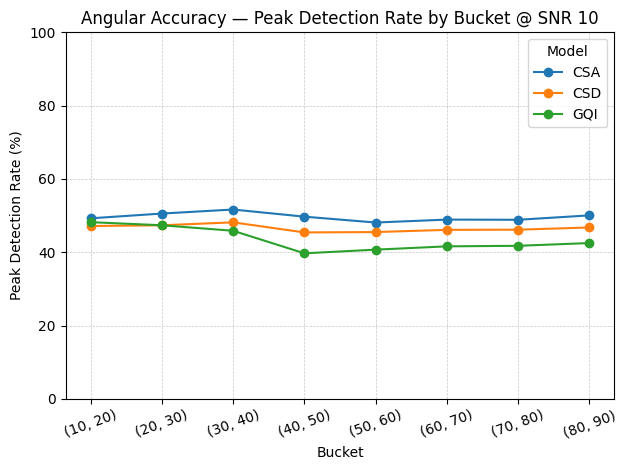

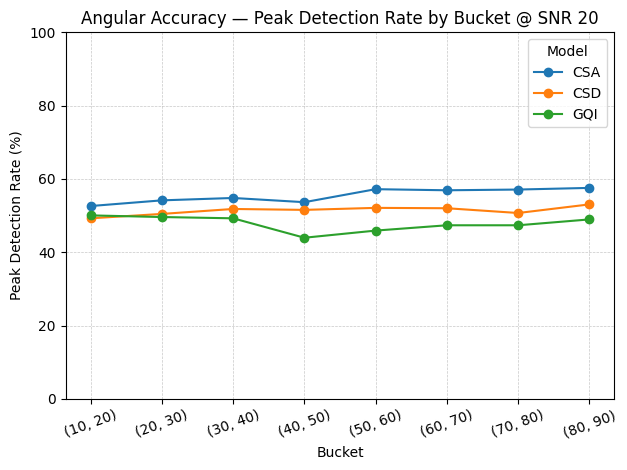

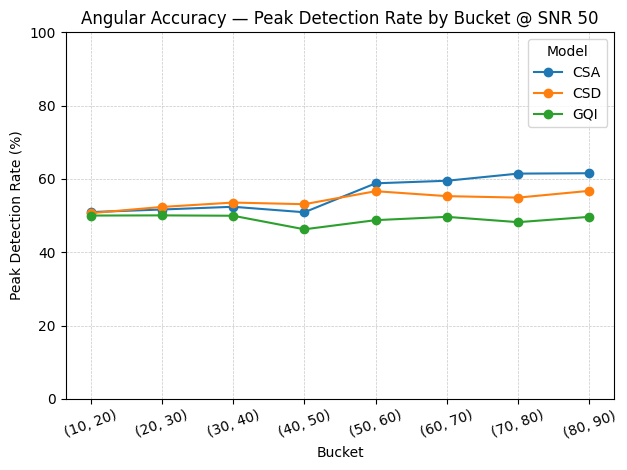

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def results_to_dataframe(advanced_model_results):
    rows = []
    for model, snr_dict in advanced_model_results.items():
        for snr_key, bucket_dict in snr_dict.items():
            try:
                snr_val = float(snr_key)
            except (TypeError, ValueError):
                snr_val = np.nan
            for bucket, metrics in bucket_dict.items():
                row = {"model": model, "snr_val": snr_val, "bucket": str(bucket)}
                if isinstance(metrics, dict):
                    row.update(metrics)
                rows.append(row)
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.dropna(subset=["snr_val"]).sort_values(["snr_val","bucket","model"]).reset_index(drop=True)
    return df

def plot_bucket_lines_per_snr(advanced_model_results, snr_list=None,
                              metric="peak_detection_rate", title_prefix=None, save=False,
                              percent_scale=True):
    df = results_to_dataframe(advanced_model_results)
    if df.empty:
        print("No numeric SNR data to plot.")
        return
    if metric not in df.columns:
        print(f"Metric '{metric}' not found.")
        return

    all_snrs = sorted(df["snr_val"].unique())
    if snr_list is None:
        snr_list = all_snrs[:3]
    else:
        norm = []
        for s in snr_list:
            try:
                f = float(s)
                if np.any(np.isclose(all_snrs, f)):
                    norm.append(f)
            except Exception:
                pass
        snr_list = norm

    for s in snr_list:
        sub = df[np.isclose(df["snr_val"], s)]
        if sub.empty:
            print(f"Skipping SNR {s}: no data.")
            continue

        buckets = sorted(sub["bucket"].unique())
        models = sorted(sub["model"].unique())
        x = np.arange(len(buckets))

        plt.figure()
        for m in models:
            ys = []
            for b in buckets:
                r = sub[(sub["bucket"] == b) & (sub["model"] == m)]
                val = r[metric].values[0] if not r.empty else np.nan
                ys.append(val)
            # -> convert to percentage
            if percent_scale:
                ys = [v * 100.0 if (v is not None and not np.isnan(v)) else np.nan for v in ys]
            plt.plot(x, ys, marker="o", label=m)

        base_label = metric.replace("_"," ").title()
        y_label = base_label + (" (%)" if percent_scale else "")
        plt.xticks(x, buckets, rotation=20)
        plt.xlabel("Bucket")
        plt.ylabel(y_label)
        plt.title((title_prefix + " — " if title_prefix else "") + f"{base_label} by Bucket @ SNR {s:g}")
        plt.legend(title="Model")
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        plt.ylim(0, 100)  # <<< clamp y to [0, 100]
        plt.tight_layout()
        if save:
            fname = f"{metric}_by_bucket_SNR_{int(s)}.png" if float(s).is_integer() else f"{metric}_by_bucket_SNR_{s}.png"
            plt.savefig(fname, dpi=200, bbox_inches="tight")
        plt.show()
plot_bucket_lines_per_snr(
    advanced_model_results,
    snr_list=snr_levels,                 # e.g., [10, 20, 30]
    metric="peak_detection_rate",        # angular accuracy
    title_prefix="Angular Accuracy",
    percent_scale=True                   # ensures 0–100 scale
)

In [42]:
bucket_accuracy_results

{0.0: {10: {(10, 20): {'fiber_count_accuracy': 0.383,
    'peak_detection_rate': 0.5815,
    'peak_precision': 0.7402928071292171,
    'peak_f1': 0.6513581629795576,
    'mean_angular_error': 7.047977142864213,
    'num_signals': 1000,
    'num_true_peaks': 2000,
    'num_pred_peaks': 1571,
    'num_matched_pairs': 1163},
   (20, 30): {'fiber_count_accuracy': 0.485,
    'peak_detection_rate': 0.6015,
    'peak_precision': 0.7064004697592484,
    'peak_f1': 0.6497434512557386,
    'mean_angular_error': 8.947062011953912,
    'num_signals': 1000,
    'num_true_peaks': 2000,
    'num_pred_peaks': 1703,
    'num_matched_pairs': 1203},
   (30, 40): {'fiber_count_accuracy': 0.597,
    'peak_detection_rate': 0.6105,
    'peak_precision': 0.6625067824199674,
    'peak_f1': 0.6354410616705698,
    'mean_angular_error': 9.91427384947649,
    'num_signals': 1000,
    'num_true_peaks': 2000,
    'num_pred_peaks': 1843,
    'num_matched_pairs': 1221},
   (40, 50): {'fiber_count_accuracy': 0.677,
  

In [43]:
import numpy as np
import pandas as pd

def results_to_dataframe(advanced_model_results):
    """
    Flattens dict[model][snr][bucket] -> metrics into a DataFrame.
    Adds:
      - snr_label: original SNR key as string
      - snr_val: numeric SNR (NaN if not parseable)
    """
    rows = []
    for model, snr_dict in advanced_model_results.items():
        for snr_key, bucket_dict in snr_dict.items():
            snr_label = str(snr_key)
            try:
                snr_val = float(snr_key)
            except (TypeError, ValueError):
                snr_val = np.nan
            for bucket, metrics in bucket_dict.items():
                row = {
                    "model": model,
                    "snr_label": snr_label,
                    "snr_val": snr_val,
                    "bucket": str(bucket),
                }
                if isinstance(metrics, dict):
                    row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    if not df.empty:
        metric_cols = [c for c in df.columns if c not in ["model","snr_val","snr_label","bucket"]]
        df = df[["model","snr_val","snr_label","bucket"] + metric_cols]
        df = df.sort_values(["snr_val","bucket","model"], na_position="last").reset_index(drop=True)
    return df

# Build and (optionally) save
df = results_to_dataframe(advanced_model_results)
print("Advanced model results DataFrame:")
print(df.head())
# Save if you want:
df.to_csv("advanced_model_results.csv", index=False)
# df.to_parquet("advanced_model_results.parquet", index=False)
# df.to_pickle("advanced_model_results.pkl")


Advanced model results DataFrame:
  model  snr_val snr_label    bucket  fiber_count_accuracy  \
0   CSA     10.0        10  (10, 20)                 0.168   
1   CSD     10.0        10  (10, 20)                 0.086   
2   GQI     10.0        10  (10, 20)                 0.026   
3   CSA     10.0        10  (20, 30)                 0.204   
4   CSD     10.0        10  (20, 30)                 0.104   

   peak_detection_rate  peak_precision   peak_f1  mean_angular_error  \
0               0.4925        0.616395  0.547526            8.298390   
1               0.4715        0.838968  0.603713            7.331606   
2               0.4820        0.935922  0.636304            7.031306   
3               0.5055        0.578045  0.539344            9.564049   
4               0.4735        0.832894  0.603762            9.107373   

   num_signals  num_true_peaks  num_pred_peaks  num_matched_pairs  
0         1000            2000            1598                985  
1         1000          

In [44]:
import pandas as pd
import numpy as np

def bucket_results_to_dataframe(bucket_accuracy_results):
    """
    Flattens dict[penalty_weight][snr][bucket] -> metrics into a DataFrame.

    Adds:
      - penalty_label: original key as string
      - penalty_weight: numeric penalty (NaN if not parseable)
      - snr_label: original SNR key as string
      - snr_val: numeric SNR (NaN if not parseable)
      - bucket: stringified bucket key
      - bucket_low, bucket_high: if bucket is a 2-tuple like (10, 20), split into columns
    """
    rows = []
    for penalty_key, snr_dict in bucket_accuracy_results.items():
        penalty_label = str(penalty_key)
        try:
            penalty_val = float(penalty_key)
        except (TypeError, ValueError):
            penalty_val = np.nan

        for snr_key, bucket_dict in snr_dict.items():
            snr_label = str(snr_key)
            try:
                snr_val = float(snr_key)
            except (TypeError, ValueError):
                snr_val = np.nan

            for bucket_key, metrics in bucket_dict.items():
                bucket_label = str(bucket_key)
                bucket_low = np.nan
                bucket_high = np.nan
                if isinstance(bucket_key, (list, tuple)) and len(bucket_key) == 2:
                    try: bucket_low = float(bucket_key[0])
                    except (TypeError, ValueError): bucket_low = np.nan
                    try: bucket_high = float(bucket_key[1])
                    except (TypeError, ValueError): bucket_high = np.nan

                row = {
                    "penalty_weight": penalty_val,
                    "penalty_label": penalty_label,
                    "snr_val": snr_val,
                    "snr_label": snr_label,
                    "bucket": bucket_label,
                    "bucket_low": bucket_low,
                    "bucket_high": bucket_high,
                }
                if isinstance(metrics, dict):
                    row.update(metrics)
                rows.append(row)

    df = pd.DataFrame(rows)
    if not df.empty:
        key_cols = ["penalty_weight","penalty_label","snr_val","snr_label","bucket","bucket_low","bucket_high"]
        metric_cols = [c for c in df.columns if c not in key_cols]
        df = df[key_cols + metric_cols]
        df = df.sort_values(["penalty_weight","snr_val","bucket"]).reset_index(drop=True)
    return df

# Build and save
df_bucket = bucket_results_to_dataframe(bucket_accuracy_results)
df_bucket.to_csv("bucket_accuracy_results.csv", index=False)


# Optional: quick peek
df_bucket.head()


,penalty_weight,penalty_label,snr_val,snr_label,bucket,bucket_low,bucket_high,fiber_count_accuracy,peak_detection_rate,peak_precision,peak_f1,mean_angular_error,num_signals,num_true_peaks,num_pred_peaks,num_matched_pairs
0,0.0,0.0,10.0,10,"(10, 20)",10.0,20.0,0.383,0.5815,0.740293,0.651358,7.047977,1000,2000,1571,1163
1,0.0,0.0,10.0,10,"(20, 30)",20.0,30.0,0.485,0.6015,0.706400,0.649743,8.947062,1000,2000,1703,1203
2,0.0,0.0,10.0,10,"(30, 40)",30.0,40.0,0.597,0.6105,0.662507,0.635441,9.914274,1000,2000,1843,1221
3,0.0,0.0,10.0,10,"(40, 50)",40.0,50.0,0.677,0.5900,0.581567,0.585753,9.643994,1000,2000,2029,1180
4,0.0,0.0,10.0,10,"(50, 60)",50.0,60.0,0.734,0.6305,0.592019,0.610654,8.647275,1000,2000,2130,1261


In [45]:
noisy_signals_dict

{10: array([[109.778244 ,  26.296585 ,  43.111282 , ...,   4.728923 ,
          52.969704 ,  57.75379  ],
        [108.88244  ,  16.184692 ,  23.808971 , ...,  32.287617 ,
          32.036182 ,   5.3169937],
        [ 97.56317  ,  54.546463 ,  26.59782  , ...,  54.24409  ,
          59.06025  ,  49.645115 ],
        ...,
        [118.226204 ,  21.585714 ,  46.762352 , ...,  18.476048 ,
          25.210306 ,  31.74594  ],
        [ 98.269394 ,  15.866339 ,  46.687057 , ...,  21.335844 ,
          18.367207 ,  32.348972 ],
        [ 87.74061  ,  29.181986 ,  14.964448 , ...,  68.94733  ,
          10.494682 ,  12.618581 ]], dtype=float32),
 20: array([[ 91.94349  ,  23.638842 ,  14.13442  , ...,   9.283777 ,
          46.769768 ,  44.404377 ],
        [100.47765  ,  24.914492 ,  25.170885 , ...,  22.050587 ,
           9.25435  ,   7.8490467],
        [ 96.96815  ,  65.65645  ,  18.078861 , ...,  43.71593  ,
          66.02581  ,  56.170464 ],
        ...,
        [ 98.62781  ,  24.76252

In [46]:
# save bvals and bvecs to file
np.savetxt("sim_bvals.txt", bvals)
np.savetxt("sim_bvecs.txt", bvecs)

import pickle
with open("noisy_signals_dict.pkl", "wb") as f:
    pickle.dump(noisy_signals_dict, f)
    

In [47]:
with open('noisy_signals_dict.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loaded_dict

{10: array([[109.778244 ,  26.296585 ,  43.111282 , ...,   4.728923 ,
          52.969704 ,  57.75379  ],
        [108.88244  ,  16.184692 ,  23.808971 , ...,  32.287617 ,
          32.036182 ,   5.3169937],
        [ 97.56317  ,  54.546463 ,  26.59782  , ...,  54.24409  ,
          59.06025  ,  49.645115 ],
        ...,
        [118.226204 ,  21.585714 ,  46.762352 , ...,  18.476048 ,
          25.210306 ,  31.74594  ],
        [ 98.269394 ,  15.866339 ,  46.687057 , ...,  21.335844 ,
          18.367207 ,  32.348972 ],
        [ 87.74061  ,  29.181986 ,  14.964448 , ...,  68.94733  ,
          10.494682 ,  12.618581 ]], dtype=float32),
 20: array([[ 91.94349  ,  23.638842 ,  14.13442  , ...,   9.283777 ,
          46.769768 ,  44.404377 ],
        [100.47765  ,  24.914492 ,  25.170885 , ...,  22.050587 ,
           9.25435  ,   7.8490467],
        [ 96.96815  ,  65.65645  ,  18.078861 , ...,  43.71593  ,
          66.02581  ,  56.170464 ],
        ...,
        [ 98.62781  ,  24.76252

In [48]:
np.savetxt("sim_bvals.txt", bvals)
np.savetxt("sim_bvecs.txt", bvecs)

In [49]:
# aggregate all matching results into a single dictionary for better plot 


# load /home/athshah/Phi/odffp_evaluation_summary_1e-4.pkl and /home/athshah/Phi/odffp_evaluation_summary.pkl
# Also load advanced_model_results.csv and bucket_accuracy_results.csv
import pickle
import pandas as pd    
with open('/home/athshah/Phi/odffp_evaluation_summary_1e-4.pkl', 'rb') as f:
    odffp_results_1e_4 = pickle.load(f)

with open('/home/athshah/Phi/odffp_evaluation_summary.pkl', 'rb') as f:
    odffp_results_default = pickle.load(f)

inverse_results = pd.read_csv('/home/athshah/Phi/advanced_model_results.csv')
bucket_results = pd.read_csv('/home/athshah/Phi/bucket_accuracy_results.csv')


In [50]:
odffp_results_1e_4

{'by_snr': {10: {'overall': {'n_signals': 8000,
    'matched_2': 3048,
    'matched_1': 3921,
    'matched_0': 1031,
    'total_gt': 16000,
    'total_matched': 10017,
    'pred_count_hist': {0: 609, 1: 0, 2: 1, 3: 7390},
    'acc@20deg_both': 0.381,
    'per_peak_recall': 0.6260625},
   'by_bucket': {(10, 20): {'n_signals': 1000,
     'matched_2': 443,
     'matched_1': 528,
     'matched_0': 29,
     'total_gt': 2000,
     'total_matched': 1414,
     'pred_count_hist': {0: 12, 1: 0, 2: 1, 3: 987},
     'acc@20deg_both': 0.443,
     'per_peak_recall': 0.707},
    (20, 30): {'n_signals': 1000,
     'matched_2': 429,
     'matched_1': 535,
     'matched_0': 36,
     'total_gt': 2000,
     'total_matched': 1393,
     'pred_count_hist': {0: 22, 1: 0, 2: 0, 3: 978},
     'acc@20deg_both': 0.429,
     'per_peak_recall': 0.6965},
    (30, 40): {'n_signals': 1000,
     'matched_2': 331,
     'matched_1': 605,
     'matched_0': 64,
     'total_gt': 2000,
     'total_matched': 1267,
     'pred_

In [51]:
import numpy as np


rows = []
by_snr = odffp_results_1e_4['by_snr']  # <- go to the correct level

for snr, snr_dict in by_snr.items():
    # per-bucket rows
    for bucket, metrics in snr_dict.get('by_bucket', {}).items():
        rows.append({
            'snr': snr,
            'bucket': bucket,  # keep the tuple; or split into low/high if you prefer
            'peak_detection_rate': metrics.get('acc@20deg_both')
        })
    # optional: add the overall row
    if 'overall' in snr_dict:
        rows.append({
            'snr': snr,
            'bucket': 'overall',
            'peak_detection_rate': snr_dict['overall'].get('acc@20deg_both')
        })

odffp_results_1e_4_df = pd.DataFrame(rows)

In [52]:
odffp_results_1e_4_df

,snr,bucket,peak_detection_rate
0,10.0,"(10, 20)",0.44300
1,10.0,"(20, 30)",0.42900
2,10.0,"(30, 40)",0.33100
3,10.0,"(40, 50)",0.35700
4,10.0,"(50, 60)",0.45200
5,10.0,"(60, 70)",0.39000
6,10.0,"(70, 80)",0.32600
7,10.0,"(80, 90)",0.32000
8,10.0,overall,0.38100
9,20.0,"(10, 20)",0.60100


In [53]:
import numpy as np


rows = []
by_snr = odffp_results_default['by_snr']  # <- go to the correct level

for snr, snr_dict in by_snr.items():
    # per-bucket rows
    for bucket, metrics in snr_dict.get('by_bucket', {}).items():
        rows.append({
            'snr': snr,
            'bucket': bucket,  # keep the tuple; or split into low/high if you prefer
            'peak_detection_rate': metrics.get('acc@20deg_both')
        })
    # optional: add the overall row
    if 'overall' in snr_dict:
        rows.append({
            'snr': snr,
            'bucket': 'overall',
            'peak_detection_rate': snr_dict['overall'].get('acc@20deg_both')
        })

odffp_results_default_df = pd.DataFrame(rows)

odffp_results_default_df

,snr,bucket,peak_detection_rate
0,10.0,"(10, 20)",0.451000
1,10.0,"(20, 30)",0.434000
2,10.0,"(30, 40)",0.331000
3,10.0,"(40, 50)",0.359000
4,10.0,"(50, 60)",0.453000
5,10.0,"(60, 70)",0.371000
6,10.0,"(70, 80)",0.320000
7,10.0,"(80, 90)",0.317000
8,10.0,overall,0.379500
9,20.0,"(10, 20)",0.603000


In [54]:
bucket_results = bucket_results[['penalty_weight', 'snr_val', 'bucket', 'peak_detection_rate']]
bucket_results

,penalty_weight,snr_val,bucket,peak_detection_rate
0,0.00,10.0,"(10, 20)",0.6380
1,0.00,10.0,"(20, 30)",0.6305
2,0.00,10.0,"(30, 40)",0.6385
3,0.00,10.0,"(40, 50)",0.6340
4,0.00,10.0,"(50, 60)",0.6620
...,...,...,...,...
155,0.01,NaN,"(40, 50)",0.4380
156,0.01,NaN,"(50, 60)",0.6350
157,0.01,NaN,"(60, 70)",0.8060
158,0.01,NaN,"(70, 80)",0.8665


In [55]:
inverse_results = inverse_results[['model', 'snr_val', 'bucket', 'peak_detection_rate']]
inverse_results

,model,snr_val,bucket,peak_detection_rate
0,CSA,10.0,"(10, 20)",0.4895
1,CSD,10.0,"(10, 20)",0.4690
2,GQI,10.0,"(10, 20)",0.4770
3,CSA,10.0,"(20, 30)",0.5040
4,CSD,10.0,"(20, 30)",0.4680
...,...,...,...,...
91,CSD,NaN,"(70, 80)",0.5920
92,GQI,NaN,"(70, 80)",0.4790
93,CSA,NaN,"(80, 90)",0.6055
94,CSD,NaN,"(80, 90)",0.5940


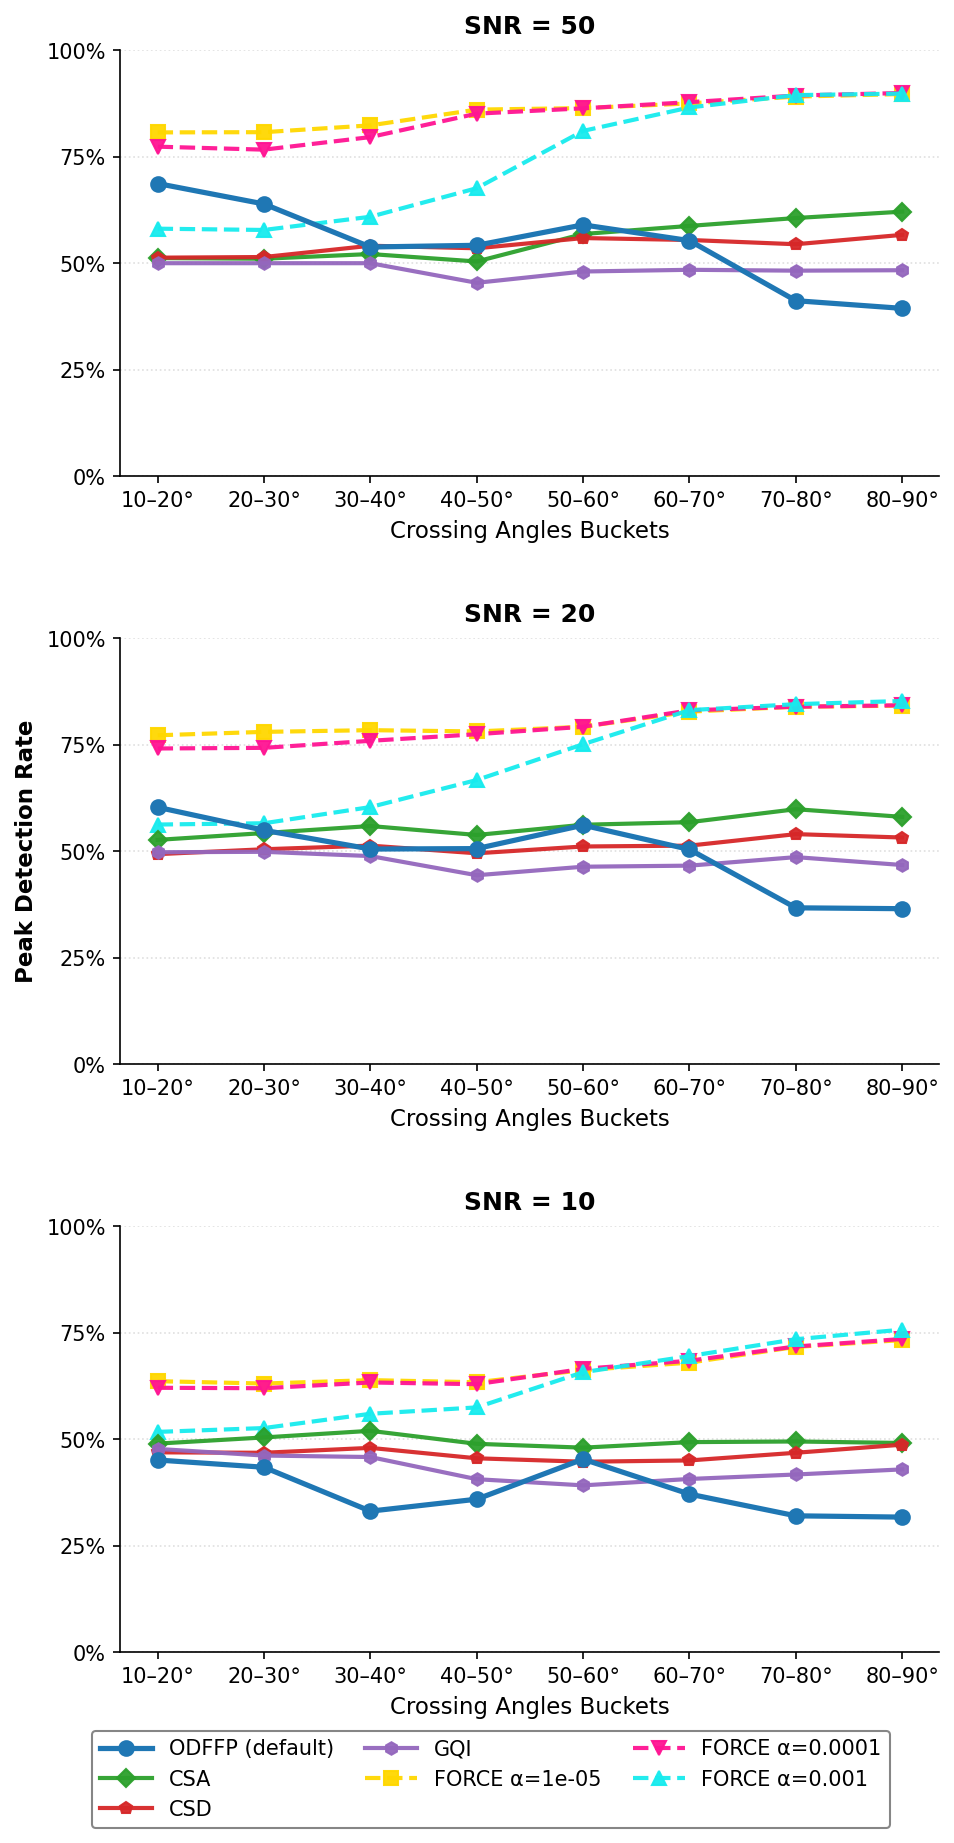

✓ Saved publication-ready figures:
  • angle_recon_publication.png
  • angle_recon_publication.pdf


(<Figure size 975x1800 with 3 Axes>,
 array([<Axes: title={'center': 'SNR = 50'}, xlabel='Crossing Angles Buckets'>,
        <Axes: title={'center': 'SNR = 20'}, xlabel='Crossing Angles Buckets', ylabel='Peak Detection Rate'>,
        <Axes: title={'center': 'SNR = 10'}, xlabel='Crossing Angles Buckets'>],
       dtype=object))

In [56]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

# ---------------------- Presentation defaults ----------------------
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.family": "sans-serif",
})

# ============================== Helpers =====================================
_bucket_re = re.compile(r"\(?\s*(\d+)\s*,\s*(\d+)\s*\)?")

def normalize_bucket(b):
    s = str(b)
    m = _bucket_re.match(s)
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"({lo}, {hi})"
    return s

def bucket_ticklabel(b):
    m = _bucket_re.match(str(b))
    if m:
        lo, hi = int(m.group(1)), int(m.group(2))
        return f"{lo}–{hi}°"
    return str(b)

def bucket_sort_key(b):
    m = _bucket_re.match(str(b))
    return int(m.group(1)) if m else 10**9

def _is_overall(x): return str(x).strip().lower() == "overall"

def _standardize_snr(df):
    df = df.copy()
    if "snr" not in df.columns and "snr_val" in df.columns:
        df["snr"] = df["snr_val"]
    return df

def fmt_alpha(val):
    try:
        v = float(val)
    except Exception:
        return str(val)
    if v == 0:
        return "0"
    if 1e-4 <= abs(v) < 1e2:
        return f"{v:g}"
    return f"{v:.0e}"

def tidy_odffp(df, label):
    df = _standardize_snr(df)
    df = df[~df["bucket"].map(_is_overall)].copy()
    df["bucket_str"] = df["bucket"].map(normalize_bucket)
    df["method"] = label
    return df[["snr", "bucket_str", "peak_detection_rate", "method"]]

def tidy_inverse(df):
    df = _standardize_snr(df)
    df = df[~df["bucket"].map(_is_overall)].copy()
    df["bucket_str"] = df["bucket"].map(normalize_bucket)
    df["method"] = df["model"].astype(str)
    return df[["snr", "bucket_str", "peak_detection_rate", "method"]]

def tidy_force(df):
    df = _standardize_snr(df)
    df = df[~df["bucket"].map(_is_overall)].copy()
    df["bucket_str"] = df["bucket"].map(normalize_bucket)
    df["method"] = df["penalty_weight"].apply(lambda a: f"FORCE α={fmt_alpha(a)}")
    return df[["snr", "bucket_str", "peak_detection_rate", "method"]]

def build_long_df(odffp_default_df, odffp_1e_4_df, force_df, inverse_df, force_keep=None):
    parts = []
    if odffp_default_df is not None: parts.append(tidy_odffp(odffp_default_df, "ODFFP (default)"))
    if odffp_1e_4_df is not None:     parts.append(tidy_odffp(odffp_1e_4_df, "ODFFP (1e-4)"))
    if inverse_df is not None:       parts.append(tidy_inverse(inverse_df))
    if force_df is not None:
        f = tidy_force(force_df)
        if force_keep is not None:
            keep_labels = {f"FORCE α={fmt_alpha(v)}" for v in force_keep}
            f = f[f["method"].isin(keep_labels)]
        parts.append(f)
    if not parts: raise ValueError("No data provided.")
    df = pd.concat(parts, ignore_index=True)
    df["snr"] = pd.to_numeric(df["snr"], errors="coerce")
    df["peak_detection_rate"] = pd.to_numeric(df["peak_detection_rate"], errors="coerce")
    return df.dropna(subset=["peak_detection_rate"])

def _alpha_value_from_label(label):
    try:
        return float(label.split("α=")[1].replace("e","E"))
    except Exception:
        return float("inf")

# ---------------- Publication-ready color palette ----------------
palette = {
    "ODFFP (default)": "#1f77b4",  # Strong blue
    "ODFFP (1e-4)":    "#ff7f0e",  # Orange
    "CSA":             "#2ca02c",  # Green
    "CSD":             "#d62728",  # Red
    "GQI":             "#9467bd",  # Purple
}
force_colors = {
    "FORCE α=1e-03": "#8c564b",  # Brown
    "FORCE α=1e-04": "#e377c2",  # Pink
    "FORCE α=1e-05": "#7f7f7f",  # Gray
    "FORCE α=0":     "#17becf",  # Cyan
}

def style_for(method):
    """
    Publication style hierarchy:
    - ODFFP: Solid lines, bold, circles/squares
    - Inverse models: Solid lines, medium weight, diamonds
    - FORCE: DASHED lines, medium weight, DISTINCT markers and colors
    """
    if method.startswith("FORCE α="):
        # FORCE methods: DASHED lines with distinct colors AND markers
        # BRIGHTER, more saturated colors for better visibility
        colors_map = {
            "FORCE α=1e-03": "#11C4F1",  # Chocolate/bright brown
            "FORCE α=0.001": "#17EBEE",  # Alternative format
            "FORCE α=1e-04": "#FF1493",  # Deep pink/magenta
            "FORCE α=0.0001": "#FF1493", # Alternative format
            "FORCE α=1e-05": "#FFD700",  # Gold/bright yellow
            "FORCE α=1e-5": "#FFD700",   # Alternative format
            "FORCE α=0":     "#00CED1",  # Dark turquoise/bright cyan
        }
        markers = {
            "FORCE α=1e-03": "^",  # triangle up
            "FORCE α=0.001": "^",
            "FORCE α=1e-04": "v",  # triangle down
            "FORCE α=0.0001": "v",
            "FORCE α=1e-05": "s",  # square
            "FORCE α=1e-5": "s",
            "FORCE α=0":     "*",  # star
        }
        # Better fallback colors (cycle through bright colors)
        fallback_colors = ["#FF6B6B", "#4ECDC4", "#FFE66D", "#A8E6CF"]
        fallback_idx = hash(method) % len(fallback_colors)
        
        return dict(
            color=colors_map.get(method, fallback_colors[fallback_idx]), 
            linestyle="--",        # DASHED
            linewidth=2.0, 
            marker=markers.get(method, "o"), 
            markersize=7, 
            markevery=1, 
            zorder=2,
            alpha=0.95  # Slightly more opaque for brightness
        )
    
    if method.startswith("ODFFP"):
        # ODFFP methods: Solid, bold lines with clear markers
        colors_map = {
            "ODFFP (1e-5)": "#1f77b4",  # Strong blue
            "ODFFP (1e-4)":    "#ff7f0e",  # Orange
        }
        markers = {
            "ODFFP (1e-5)": "o",  # circle
            "ODFFP (1e-4)":    "s",  # square
        }
        return dict(
            color=colors_map.get(method, "#1f77b4"), 
            linestyle="-",         # SOLID
            linewidth=2.5, 
            marker=markers.get(method, "o"), 
            markersize=7, 
            markevery=1, 
            zorder=4,
            alpha=1.0
        )
    
    # Inverse models: Solid lines, medium weight, distinct colors and markers
    colors_map = {
        "CSA": "#2ca02c",  # Green
        "CSD": "#d62728",  # Red
        "GQI": "#9467bd",  # Purple
    }
    markers = {
        "CSA": "D",  # diamond
        "CSD": "p",  # pentagon
        "GQI": "h",  # hexagon
    }
    # Better fallback for inverse models
    fallback_colors = ["#2ca02c", "#d62728", "#9467bd", "#bcbd22"]
    fallback_idx = hash(method) % len(fallback_colors)
    
    return dict(
        color=colors_map.get(method, fallback_colors[fallback_idx]), 
        linestyle="-",             # SOLID
        linewidth=2.0, 
        marker=markers.get(method, "D"), 
        markersize=6, 
        markevery=1, 
        zorder=3,
        alpha=0.95
    )

# ============================ Plot function =================================
def plot_peak_detection_solid(
    odffp_default_df,
    odffp_results_1e_4_df,
    bucket_results,
    inverse_results,
    snrs=(50.0, 20.0, 10.0),
    force_keep=(1e-3, 1e-4, 1e-5),
    outfile_png="angle_recon_publication.png",
    outfile_pdf="angle_recon_publication.pdf",
):
    df = build_long_df(odffp_default_df, odffp_results_1e_4_df, bucket_results, inverse_results, force_keep=force_keep)

    # Narrower, taller aspect ratio for publication
    fig, axes = plt.subplots(3, 1, figsize=(6.5, 12.0), sharex=False, sharey=True)

    handles_by_label = {}
    for ax, snr in zip(axes, snrs):
        sub = df[df["snr"] == float(snr)].copy()
        ax.set_title(f"SNR = {int(snr)}", pad=8, fontweight='semibold')

        if sub.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center")
            continue

        buckets = sorted(sub["bucket_str"].unique(), key=bucket_sort_key)
        x = np.arange(len(buckets))

        for method, g in sub.groupby("method", sort=False):
            y_map = dict(zip(g["bucket_str"], g["peak_detection_rate"]))
            y = [y_map.get(b, np.nan) for b in buckets]
            st = style_for(method)
            (line,) = ax.plot(x, y, **st, label=method)
            handles_by_label[method] = line

        # X ticks as bucket labels
        ax.set_xticks(x)
        ax.set_xticklabels([bucket_ticklabel(b) for b in buckets], rotation=0)
        ax.set_xlabel("Crossing Angles Buckets", fontsize=11)
        ax.set_ylim(0, 1.0)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.yaxis.set_major_locator(mtick.MultipleLocator(0.25))
        ax.grid(True, axis="y", linestyle=":", alpha=0.4, linewidth=0.8)

    # Y-label only on middle panel for cleaner look
    axes[1].set_ylabel("Peak Detection Rate", fontsize=11, fontweight='semibold')

    # ---------- Legend: ODFFP → Inverse → FORCE ----------
    labels_all = list(handles_by_label.keys())
    odffp_labels   = [m for m in labels_all if m.startswith("ODFFP")]
    inverse_labels = [m for m in labels_all if m in {"CSA","CSD","GQI","GQI2"}]
    force_labels   = sorted([m for m in labels_all if m.startswith("FORCE α=")], key=_alpha_value_from_label)

    legend_labels  = odffp_labels + inverse_labels + force_labels
    legend_handles = [handles_by_label[m] for m in legend_labels]

    # Place legend at bottom center to avoid overlapping with plot titles
    fig.legend(
        legend_handles, legend_labels,
        loc="lower center", bbox_to_anchor=(0.5, -0.02),
        ncol=3,  # 3 columns for horizontal layout at bottom
        frameon=True, fancybox=True, shadow=False,
        handlelength=2.5, columnspacing=1.5, 
        borderaxespad=0.2, edgecolor='gray', framealpha=0.95
    )

    fig.subplots_adjust(top=0.97, left=0.12, right=0.96, bottom=0.08, hspace=0.38)

    # Save + show
    # fig.savefig(outfile_png, bbox_inches="tight", dpi=600)
    # fig.savefig(outfile_pdf, bbox_inches="tight")
    plt.show()
    print(f"✓ Saved publication-ready figures:")
    print(f"  • {outfile_png}")
    print(f"  • {outfile_pdf}")
    return fig, axes

# ============================== Run it ======================================
# Uncomment and run when your DataFrames are available
plot_peak_detection_solid(
    odffp_results_default_df,
    None,
    bucket_results,
    inverse_results,
    snrs=(50.0, 20.0, 10.0),
    force_keep=(1e-3, 1e-4, 1e-5),
)


In [57]:
# Generate 1000 random signals for 1 fiber, 2 fiber and 3 fiber



## Generate 1000 random diffusion-tensor signals and add Rician noise (SNR = 10, 20, 50)
This section creates 1000 synthetic diffusion MRI signals using a single-tensor model with random orientations and eigenvalues, based on the provided `sim_bvals.txt` and `sim_bvecs.txt`. Signals are S0-scaled (S0 ≈ 100), and Rician noise is added at three SNR levels. Saved to `outputs/simulated_signals_1000.npz`.

In [58]:
import numpy as np


def generate_single_fiber():
    """Generate a single-fiber diffusion signal with random parameters."""
    # choose intra and extra axonal fractions with free water for compartments between 30 and 70%
    f_intra = np.random.uniform(0.6, 0.9)
    f_extra = 1 - f_intra

    fiber_fractions = 1

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_intra)
    else:
        d_perp_extra = np.random.uniform(0.3e-3,0.8e-3)

    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 1)[0]
    true_stick = target_sphere[index]
    factor = np.random.choice(odi_list)

    fodf_gt = bingham_sf[index][factor]
    fodf_gt = fodf_gt / np.sum(fodf_gt)

    S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
    S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

    # simulate the signal
    S = fiber_fractions*(f_intra * S_in + f_extra * S_ex)

    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick, axis=1))] = 1
    labels[index] = 1
    return S * S0, labels, 1, factor, 0, fiber_fractions * f_intra, fodf_gt, d_par, f_extra * d_perp_extra, [1,0,0], [f_intra]


def generate_two_fibers():
    """Generate a two-fiber diffusion signal with random parameters (from simulation.py)."""
    f_in = np.random.uniform(0.6,0.9,2)
    fiber_frac1 = np.random.uniform(0.2,0.8)
    fiber_fractions = [fiber_frac1,1 - fiber_frac1]

    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3,0.8e-3)

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = d_perp_extra

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 2)
    while index[0] == index[1]:
        index = np.random.randint(0, target_sphere.shape[0], 2)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    factor = np.random.choice(odi_list)
    
    S = np.zeros((len(bvals)))
    fodf = np.zeros((target_sphere.shape[0]))
    for i in range(2):
        fodf_gt = bingham_sf[index[i]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fractions[i] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

        f_intra = f_in[i]
        f_extra = 1 - f_intra
        
        S += fiber_fractions[i]*(f_intra * S_in + f_extra * S_ex)

        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
        # labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
        labels[index[0]] = 1
        labels[index[1]] = 1
    return S * S0, labels , 2, factor, 0, fiber_fractions[0] * f_in[0] + fiber_fractions[1] * f_in[1], fodf, d_par, fiber_fractions[0] * (1 - f_in[0])* d_perp_extra + fiber_fractions[1] * (1 - f_in[1]) * d_perp_extra, [fiber_frac1, 1 - fiber_frac1, 0], f_in


def generate_three_fibers():
    """Generate a three-fiber diffusion signal with random parameters."""
    f_in = np.random.uniform(0.6,0.9,3)
    fiber_fracs = np.random.dirichlet([1, 1, 1])
    while any(fiber_fracs < 0.2):
        fiber_fracs = np.random.dirichlet([1, 1, 1])
    d_par = np.random.uniform(2.0e-3,3.0e-3)
    if tortuisity:
        d_perp_extra = get_dperp_extra(d_par, f_in[0])
    else:
        d_perp_extra = np.random.uniform(0.3e-3,0.8e-3)

    labels = np.zeros((target_sphere.shape[0]))
    S0 = 100
    mevals_ex = np.zeros(np.shape(target_sphere))
    mevals_ex[:, 0] = d_par
    mevals_ex[:, 1] = d_perp_extra
    mevals_ex[:, 2] = mevals_ex[:, 1]

    mevals_in = np.zeros(np.shape(target_sphere))
    mevals_in[:, 0] = d_par
    mevals_in[:, 1] = 0.e-3
    mevals_in[:, 2] = 0.e-3

    # Select a random fiber orientation from the target sphere
    index = np.random.randint(0, target_sphere.shape[0], 3)

    # if indexes are closer than 60 degrees, choose another one
    while (not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[1]]),threshold=70) or 
    not is_angle_valid(angle_between(target_sphere[index[0]], target_sphere[index[2]]),threshold=70) or 
    not is_angle_valid(angle_between(target_sphere[index[1]], target_sphere[index[2]]),threshold=70)):
        index = np.random.randint(0, target_sphere.shape[0], 3)

    true_stick1 = target_sphere[index[0]]
    true_stick2 = target_sphere[index[1]]
    true_stick3 = target_sphere[index[2]]
    factor = np.random.choice(odi_list)
    
    fodf = np.zeros((target_sphere.shape[0]))
    S = np.zeros((len(bvals)))
    for k in range(3):
        fodf_gt = bingham_sf[index[k]][factor]
        fodf_gt = fodf_gt / np.sum(fodf_gt)

        fodf += fiber_fracs[k] * fodf_gt

        S_in = multi_tensor(mevals_in, evecs, fodf_gt*100, bvals, bvecs)
        S_ex = multi_tensor(mevals_ex, evecs, fodf_gt*100, bvals, bvecs)

        S+= fiber_fracs[k]*(f_in[k] * S_in + (1 - f_in[k]) * S_ex)

    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick1, axis=1))] = 1
    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick2, axis=1))] = 1
    # labels[np.argmin(np.linalg.norm(target_sphere - true_stick3, axis=1))] = 1
    labels[index[0]] = 1
    labels[index[1]] = 1
    labels[index[2]] = 1
    return S * S0, labels , 3, factor, 0, fiber_fracs[0] * f_in[0] + fiber_fracs[1] * f_in[1] + fiber_fracs[2] * f_in[2], fodf, d_par, fiber_fracs[0] * (1 - f_in[0]) * d_perp_extra + fiber_fracs[1] * (1 - f_in[1]) * d_perp_extra + fiber_fracs[2] * (1 - f_in[2]) * d_perp_extra, fiber_fracs, f_in


def get_dperp_extra(d_par, f_intra):
    """Calculate perpendicular diffusivity based on tortuosity model."""
    return d_par * (1 - f_intra) / (1 + f_intra)


def create_wm_signal(num_fib):
    """Generate a white matter signal with random fiber configuration."""
    if num_fib == 1:
        return generate_single_fiber()
    elif num_fib == 2:
        return generate_two_fibers()
    elif num_fib == 3:
        return generate_three_fibers()
    
def create_gm_signal_sim():
    """Generate a gray matter signal (isotropic)."""
    d = 1.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, np.zeros(len(target_sphere)), 0, 1.0, 0.0, 0.0, np.ones(len(target_sphere))/len(target_sphere), d, d


def create_csf_signal_sim():
    """Generate a CSF signal (isotropic)."""
    d = 3.0e-3
    signal = np.exp(-bvals * d) * 100
    return signal, np.zeros(len(target_sphere)), 0, 1.0, 1.0, 0.0, np.zeros(len(target_sphere)), d , d


def create_mixed_signal(num_fib_choose=None):
    """Generate a mixed signal combining WM, GM, and CSF."""
    # Randomly sample fractions for WM, GM, and CSF
    fractions = [0,0,0]
    while fractions[0] < 0.8:
        fractions = np.random.dirichlet([2, 1, 1])  # WM, GM, CSF

    wm_fraction = fractions[0]
    gm_fraction = fractions[1]
    csf_fraction = fractions[2]

    # Choose a random number of fibers for WM
    if num_fib_choose:
        num_fiber = num_fib_choose
    else:
        num_fiber = np.random.choice([1,2,3], p=[0.1, 0.2, 0.7])

    # create signals for each tissue type
    wm_signal, wm_label, wm_num_fib, wm_disp, _, wm_nd, wm_odf, wm_d_par, wm_d_perp, fracs, f_ins = create_wm_signal(num_fib=num_fiber)
    gm_signal, _, _, gm_disp, _, gm_nd, gm_odf, gm_d_par, gm_d_perp = create_gm_signal_sim()
    csf_signal, _, _, _, csf_fw, _, csf_odf, csf_d_par, csf_d_perp = create_csf_signal_sim()
    
    # Combine signals weighted by tissue fractions
    combined_signal = fractions[0] * wm_signal + fractions[1] * gm_signal + fractions[2] * csf_signal
    
    # Get the combined ODI and ND
    odi = wm_fraction * wm_disp + gm_fraction * gm_disp + csf_fraction * 1.0
    nd = wm_fraction * wm_nd + gm_fraction * gm_nd

    combined_odf = np.zeros((724,))

    # Return all the metrics and signals
    return (
        combined_signal,
        wm_label,
        wm_num_fib,
        odi,
        wm_fraction,
        gm_fraction,
        csf_fraction,
        nd,
        combined_odf.astype(np.float16),
        fracs
    )


# Define Ray remote function
@ray.remote
def generate_mixed(n):
    return create_mixed_signal(n)

# Initialize Ray
if ray.is_initialized():
    ray.shutdown()
    
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
print(f"Ray initialized with {num_cpus} CPUs")


# Generate mixed signals in parallel
print(f"Starting simulation of {num_simulations:,} signals...")
print(f"This will generate 1, 2, and 3 fiber configurations with GM and CSF tissue fractions")

# Submit all tasks
one_fib = 10000
two_fib = 10000
three_fib = 10000
futures = []
futures.extend([generate_mixed.remote(1) for _ in range(one_fib)])
futures.extend([generate_mixed.remote(2) for _ in range(two_fib)])
futures.extend([generate_mixed.remote(3) for _ in range(three_fib)])

# Gather results
results = ray.get(futures)
signals = np.stack([r[0] for r in results]).astype(np.float32)  

print(f"\nSimulation complete! Generated {len(results):,} signals")

#merge the generated 30000 samples and add noise at 3 levels that is 10,20 and 50 and store them seperately.

2025-11-22 20:54:49,590	INFO worker.py:1781 -- Started a local Ray instance.


Ray initialized with 16 CPUs
Starting simulation of 1,000,000 signals...
This will generate 1, 2, and 3 fiber configurations with GM and CSF tissue fractions
(raylet) Warning: The remote function __main__.generate_mixed is very large (40 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.

Simulation complete! Generated 30,000 signals


In [59]:
from dipy.sims.voxel import add_noise
snr_levels = [10, 20, 50]
noisy_signals_dict = {}
for snr in snr_levels:
    noisy_signals = add_noise(signals, snr, S0=100, noise_type='rician')
    noisy_signals_dict[snr] = noisy_signals

    

In [60]:
noisy_signals_dict

{10: array([[ 89.99897682,  56.28225465,  28.70495699, ...,  27.50543792,
          30.89138375,  38.7154333 ],
        [104.70952656,  31.80839732,  44.67761634, ...,  27.9088733 ,
          40.38327483,  51.45289742],
        [103.09828498,  51.50931093,  26.95886198, ...,  44.21974161,
          37.53964687,  40.39416865],
        ...,
        [111.60145708,  33.05163008,  39.68183125, ...,  26.84999142,
          33.39620924,  41.52514743],
        [116.49424568,   6.5473571 ,  44.36566589, ...,  33.44623154,
          28.04348166,  34.89772651],
        [ 89.87792103,  42.05218526,  35.37221261, ...,  23.21319806,
          26.94341215,  43.53825501]]),
 20: array([[104.37872102,  41.98621612,  47.32878576, ...,  42.88710066,
          27.31696541,  38.66416735],
        [103.8448709 ,  28.87857462,  52.42074054, ...,  34.61711934,
          41.36974044,  48.28405117],
        [ 97.62970389,  34.40345889,  18.51027708, ...,  44.68979756,
          39.63747898,  42.20425365],
     

In [ ]:
penalty_values = [0.0, 0.00001, 0.0001, 0.001]
 
nufo_results = {}
for penalty in penalty_values:
    print(f"Processing penalty weight: {penalty}")
    penalized_array = penalty * num_fibers_array
    #match signals with noisy signals at different SNR levels
    nufo_results[penalty] = {}
    for snr, noisy_signals in noisy_signals_dict.items():
        print(f"  SNR level: {snr}")
        distances, faiss_indices = match_signals_faiss_with_penalty(
            index, noisy_signals, penalized_array, k=50, batch_size=10000
        )
        nufo_results[penalty][snr] = {
            "nufo": num_fibers_array[faiss_indices]
        }
nufo_results

Processing penalty weight: 0.0
  SNR level: 10


Matching batches with penalty:   0%|          | 0/3 [00:00<?, ?it/s]

Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.62s/it]


  SNR level: 20


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.58s/it]


  SNR level: 50


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.36s/it]


Processing penalty weight: 1e-05
  SNR level: 10


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.46s/it]


  SNR level: 20


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.47s/it]


  SNR level: 50


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.56s/it]


Processing penalty weight: 0.0001
  SNR level: 10


Matching batches with penalty: 100%|██████████| 3/3 [00:19<00:00,  6.64s/it]


  SNR level: 20


Matching batches with penalty:  33%|███▎      | 1/3 [00:06<00:13,  6.59s/it]

In [ ]:
# divide the nufo_results into accuracy. the first 10000 signals are 1 fiber, next 10000 are 2 fibers and last 10000 are 3 fibers. Calculate accuracy for each bucket of crossing angles. Store the results in a dictionary.
nufo_accuracy_results = {}
for penalty, snr_dict in nufo_results.items():
    nufo_accuracy_results[penalty] = {}

    for snr, results in snr_dict.items():
        nufo_accuracy_results[penalty][snr] = {}
        nufo = results["nufo"]

        # Divide the nufo results into accuracy buckets
        for i in range(3):
            bucket = nufo[i * 10000:(i + 1) * 10000]
            expected_fiber_count = i + 1
            
            # Use numpy comparison to handle array elements
            correct_predictions = (bucket == expected_fiber_count).sum()
            accuracy = correct_predictions / len(bucket) if len(bucket) > 0 else 0
            
            nufo_accuracy_results[penalty][snr][f"fiber_{expected_fiber_count}"] = accuracy

print(nufo_accuracy_results)


{0.0: {10: {'fiber_1': 0.4531, 'fiber_2': 0.685, 'fiber_3': 0.9813}, 20: {'fiber_1': 0.8006, 'fiber_2': 0.8697, 'fiber_3': 0.9845}, 50: {'fiber_1': 0.9835, 'fiber_2': 0.9144, 'fiber_3': 0.9903}}, 1e-05: {10: {'fiber_1': 0.4592, 'fiber_2': 0.685, 'fiber_3': 0.9808}, 20: {'fiber_1': 0.8089, 'fiber_2': 0.8687, 'fiber_3': 0.9838}, 50: {'fiber_1': 0.987, 'fiber_2': 0.9131, 'fiber_3': 0.9898}}, 0.0001: {10: {'fiber_1': 0.5149, 'fiber_2': 0.6866, 'fiber_3': 0.9759}, 20: {'fiber_1': 0.8774, 'fiber_2': 0.8564, 'fiber_3': 0.9765}, 50: {'fiber_1': 0.9985, 'fiber_2': 0.8897, 'fiber_3': 0.9838}}, 0.001: {10: {'fiber_1': 0.8687, 'fiber_2': 0.6585, 'fiber_3': 0.8688}, 20: {'fiber_1': 0.9996, 'fiber_2': 0.6894, 'fiber_3': 0.8557}, 50: {'fiber_1': 1.0, 'fiber_2': 0.6842, 'fiber_3': 0.8615}}}


In [ ]:
# GitHub Copilot
# Apply CSA, GQI, and CSD to the 30k noisy signals, count peaks (NUFO), and compute accuracy vs. ground truth

# Preconditions:
# - noisy_signals_dict: dict {SNR -> (N, N_grad)} from cell 65
# - gtab, sphere, response (for CSD), get_valid_peak_dirs (cell 41)
# - models may already exist (csa, gqi, csd). Build if missing.
# - one_fib, two_fib, three_fib: counts per class defined in cell 64

# Build models if not present

from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel
from dipy.reconst.gqi import GeneralizedQSamplingModel
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model
# get a response function from the signals by getting signal with FA > 0.8
import dipy.reconst.dti as dti
dti_model  = dti.TensorModel(gtab)
dti_fit    = dti_model.fit(np.array(signals))
fa_values  = dti_fit.fa
high_fa_indices = np.where(fa_values > 0.8)[0]

evals = dti_fit.evals[high_fa_indices]
mean_evals = np.mean(evals, axis=0)

print("Estimated response function eigenvalues (from FA > 0.8):", mean_evals)
estimate = np.array(mean_evals, dtype=float)
ratio = 1/mean_evals.sum()
response = (estimate, ratio)
print("Response function", response)

def get_valid_peak_dirs(peak_dirs_all):
    """
    peak_dirs_all: array-like of shape (Q, K, 3) (padded with zeros for missing peaks) 
                   or list/array where each item is (K,3).
    Returns:
      dirs_list: list of length Q; each item is (n_i, 3) unit vectors
      counts   : np.array shape (Q,) number of valid peaks per sample
    """
    peak_dirs_all = np.asarray(peak_dirs_all, dtype=np.float32)
    if peak_dirs_all.ndim == 2 and peak_dirs_all.shape[-1] == 3:
        peak_dirs_all = peak_dirs_all[np.newaxis, ...]  # single-sample case

    Q = peak_dirs_all.shape[0]
    dirs_list, counts = [], np.zeros(Q, dtype=np.int32)

    for i in range(Q):
        dirs_i = np.atleast_2d(peak_dirs_all[i])  # (K,3)
        valid = np.linalg.norm(dirs_i, axis=-1) > 1e-6
        V = dirs_i[valid]
        if V.size:
            V = V / np.linalg.norm(V, axis=-1, keepdims=True)
        dirs_list.append(V)
        counts[i] = V.shape[0]
    return dirs_list, counts
try:
    csa
except NameError:
    csa = CsaOdfModel(gtab, sh_order=8)
try:
    gqi
except NameError:
    gqi = GeneralizedQSamplingModel(gtab, sampling_length=1.25)
try:
    csd
except NameError:
    # CSD needs 'response' computed earlier (cell 40). Skip if unavailable.
    if 'response' in globals():
        csd = ConstrainedSphericalDeconvModel(gtab, response=response, sh_order=8)
    else:
        csd = None
        print("Warning: 'response' not found. Skipping CSD.")

# Ground-truth NUFO for the 30k set
n1, n2, n3 = int(one_fib), int(two_fib), int(three_fib)
true_nufo = np.concatenate([np.full(n1, 1, dtype=np.int32),
                            np.full(n2, 2, dtype=np.int32),
                            np.full(n3, 3, dtype=np.int32)])
n_total = true_nufo.size

def count_peaks_from_peaksobj(peaks_obj):
    # Use helper from cell 41 for robust counting
    _, counts = get_valid_peak_dirs(peaks_obj.peak_dirs)
    return counts.astype(np.int32)

def per_class_accuracy(pred_counts, true_counts, class_val):
    mask = (true_counts == class_val)
    if not np.any(mask):
        return 0.0
    return float(np.mean(pred_counts[mask] == true_counts[mask]))

nufo_accuracy_inverse = {}  # model -> snr -> dict of accuracies

for snr, noisy_sigs in noisy_signals_dict.items():
    # CSA
    peaks_csa = peaks_from_model(
        csa, noisy_sigs, sphere,
        relative_peak_threshold=0.5,
        min_separation_angle=10,
        mask=None, parallel=True
    )
    pred_csa = count_peaks_from_peaksobj(peaks_csa)

    # GQI
    peaks_gqi = peaks_from_model(
        gqi, noisy_sigs, sphere,
        relative_peak_threshold=0.5,
        min_separation_angle=10,
        mask=None, parallel=True
    )
    pred_gqi = count_peaks_from_peaksobj(peaks_gqi)

    # CSD (if available)
    if csd is not None:
        peaks_csd = peaks_from_model(
            csd, noisy_sigs, sphere,
            relative_peak_threshold=0.5,
            min_separation_angle=10,
            mask=None, parallel=True
        )
        pred_csd = count_peaks_from_peaksobj(peaks_csd)

    # Collect accuracies
    for model_name, pred in (("CSA", pred_csa), ("GQI", pred_gqi), ("CSD", pred_csd if csd is not None else None)):
        if pred is None:
            continue

        overall = float(np.mean(pred == true_nufo))
        acc1 = per_class_accuracy(pred, true_nufo, 1)
        acc2 = per_class_accuracy(pred, true_nufo, 2)
        acc3 = per_class_accuracy(pred, true_nufo, 3)

        nufo_accuracy_inverse.setdefault(model_name, {})[snr] = {
            "overall_accuracy": overall,
            "fiber_1_accuracy": acc1,
            "fiber_2_accuracy": acc2,
            "fiber_3_accuracy": acc3,
            "n_total": int(n_total),
            "n1": int(n1),
            "n2": int(n2),
            "n3": int(n3),
        }

# Brief summary printout
for model_name, snr_dict in nufo_accuracy_inverse.items():
    print(f"\n{model_name} NUFO accuracy:")
    for snr, metrics in snr_dict.items():
        print(f"  SNR={snr}: overall={metrics['overall_accuracy']:.3f} | "
              f"1-fib={metrics['fiber_1_accuracy']:.3f}, "
              f"2-fib={metrics['fiber_2_accuracy']:.3f}, "
              f"3-fib={metrics['fiber_3_accuracy']:.3f}")

# nufo_accuracy_inverse now holds accuracies per model and SNR

Estimated response function eigenvalues (from FA > 0.8): [0.00197555 0.00022491 0.00021101]
Response function (array([0.00197555, 0.00022491, 0.00021101]), 414.6840963995418)

CSA NUFO accuracy:
  SNR=10: overall=0.200 | 1-fib=0.385, 2-fib=0.132, 3-fib=0.081
  SNR=20: overall=0.348 | 1-fib=0.571, 2-fib=0.234, 3-fib=0.238
  SNR=50: overall=0.590 | 1-fib=0.958, 2-fib=0.366, 3-fib=0.445

GQI NUFO accuracy:
  SNR=10: overall=0.395 | 1-fib=0.951, 2-fib=0.168, 3-fib=0.067
  SNR=20: overall=0.383 | 1-fib=0.994, 2-fib=0.109, 3-fib=0.046
  SNR=50: overall=0.378 | 1-fib=1.000, 2-fib=0.091, 3-fib=0.044

CSD NUFO accuracy:
  SNR=10: overall=0.427 | 1-fib=0.675, 2-fib=0.290, 3-fib=0.318
  SNR=20: overall=0.448 | 1-fib=0.727, 2-fib=0.319, 3-fib=0.300
  SNR=50: overall=0.465 | 1-fib=0.769, 2-fib=0.329, 3-fib=0.296


In [ ]:
# save signals and results to disk using pickle
import pickle

with open("noisy_signals_nufo.pkl", "wb") as f:
    pickle.dump(noisy_signals_dict, f)

with open("nufo_accuracy.pkl", "wb") as f:
    pickle.dump(nufo_accuracy_inverse, f)

with open("nufo_accuracy_penalty.pkl", "wb") as f:
    pickle.dump(nufo_accuracy_results, f)


In [ ]:
# save bvals and bvecs to disk
np.savetxt("bvals_nufo.txt", bvals)
np.savetxt("bvecs_nufo.txt", bvecs)